### 
read a Axioscan 7 czi image by scene
contrast stretch
center by training image mean
tile each scene to 2560 x 1920
name each tile by org image name + tile coordinates + contrast stretch
write as png



In [1]:
import os
import sys
import json
import uuid as uuid
import cv2
import re
import shutil
from operator import itemgetter
import math
import random
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import shapely
import shapely.geometry
from shapely.geometry import Polygon,MultiPolygon,GeometryCollection
from shapely.validation import make_valid
from shapely.geometry import mapping
import geopandas as gpd

import imgfileutils as imf
#import segmentation_tools as sgt
from aicsimageio import AICSImage, imread
from skimage import measure, segmentation
from skimage.measure import regionprops
from skimage.color import label2rgb
import progressbar
from IPython.display import display, HTML
from MightyMosaic import MightyMosaic

import argparse
import glob
import bioformats
import javabridge
from PIL import Image

import csv

In [2]:
# setup directory
root = r'/Users/lovely_shufan/'
project_dir = root + r'Dropbox (Edison_Lab@UGA)/AMF/AMF Imaging 2022/0_inference_using_MaskRCNN_2021/'
rawdata_dir = project_dir + r'0_raw_czi/GA_MINE_2022_imaged_by_Isabella_Wilson/'
output_dir = project_dir + r'1_tile_png/GA_MINE_2022_imaged_by_Isabella_Wilson/'

#os.makedirs(rawdata_dir, exist_ok=True)
#os.makedirs(output_dir, exist_ok=True)

# address to training images
trainimg_dir = root + r'Dropbox (Edison_Lab@UGA)/Projects/Bioinformatics_modeling/am_fungi_segmentation/data/set1/image'

In [98]:
def centering2train(diff, img):
    row = img.shape[0]
    col = img.shape[1]
    times = row * col
    for i in range(0,3,1):
        diffarray = np.repeat(diff[i], times, axis = 0)
        diffmx = diffarray.reshape((row,col))
        img[:,:,i] = np.add(img[:,:,i],diffmx)
        img[img > 255] = 255
        img[img < 0] = 0
    return img

def plotImg(images, titles):
    fig, axs = plt.subplots(nrows = math.ceil(len(images)/2), 
                            ncols = 2,
                            #ncols = len(images),
                          figsize = (100, 100))
    axs = axs.flatten()
    for i, p in enumerate(images):
        #print(type(p))
        axs[i].imshow(cv2.cvtColor(p, cv2.COLOR_BGR2RGB))
        axs[i].set_title(titles[i])
        axs[i].title.set_size(40)
        #axs[i].axis('off')
    plt.show()

def plotColorHist(image):
    # plot color channel histogram
    blue,green,red = cv2.split(image) #extract red channels
    channels = [blue, green, red]
    channel_names = ['blue','green','red']
    plt.figure()
    plt.xlim([0, 256])
    for i in range(0,3,1):
        histogram, bin_edges = np.histogram(image[:, :, i], bins=256, range=(0, 256))
        plt.plot(bin_edges[0:-1], histogram, color=channel_names[i])
        plt.axvline(x = np.percentile(channels[i].ravel(), 98), color = channel_names[i])
    plt.title("Color Histogram")
    plt.xlabel("Color value")
    plt.ylabel("Pixel count")
    plt.show()
    
def contrast_stretch(r,newmax):
    a = 0
    b = 255
    c = 0
    d = newmax
    s = (r-c)*((b-a)/(d-c))+a  
    s[s > 255] = 255 #converting all pixels above 98 percentile to 255
    return np.array(s, dtype = np.uint8) # Specify the data type so that float value will be converted to int

def contrastStretch(image):
    blue,green,red = cv2.split(image)
    channels = [blue, green, red]
    channel_names = ['blue','green','red']
    newmax = np.percentile(red.ravel(),98)
    new_channels = []
    for i in range(0,3,1):
        csimg = contrast_stretch(channels[i],newmax)
        new_channels.append(csimg)
        #cv2.imwrite(os.path.join(output_dir, "_".join([file.replace('.png', ''),channel_names[i],'contrast_stretch.png'])), csimg)
    new_img = np.dstack((new_channels[0],new_channels[1],new_channels[2]))
    return new_img
            
def padImg(img, tilex, tiley):
    '''
    :param img:
    :return padded img:
    
    :rtype ndnumpy.array:
    Objective: output a padded image dividle by tile size
    '''
    y = img.shape[0]
    x = img.shape[1]
    pad_top = tiley - (y % tiley)
    pad_lft = tilex - (x % tilex)
    img = cv2.copyMakeBorder(img,pad_top,0,pad_lft,0,cv2.BORDER_CONSTANT,value=[0,0,0])
    
    return img

def makeTiles(file, scene, img, tilex, tiley, output_dir):
    '''
    :param file: name of axioscan7 image file
    :paramtype str:
    :param scene: name of scene
    :paramtype str:
    :param img: 
    :paramtype ndnumpy.array:
    :param tilesize: size of desired tile 
    :paramtype int:  
    :param outputdir: 
    :paramtype str:

    Objective: write tiled images to output dir
    '''
    for i in range(0,img.shape[0],tiley):
        for j in range(0,img.shape[1],tilex):
            #print(i, " ", j)
            #tile = [[j, i],[j, i+1024], [j+1024, i], [j+1024, i+1024]]
            xmin = j
            xmax = j + tilex
            ymin = i
            ymax = i + tiley
            
            subimg = img[ymin:ymax,xmin:xmax]
            tile_id = file[:-4] + '_' +scene + '_' +str(xmin)+"_"+str(ymin)+"_"+str(xmax)+"_"+str(ymax)
            
            # write the tile image to the output directory
            cv2.imwrite(os.path.join(output_dir,tile_id+'.png'),subimg)    

#  computing the per-channel mean for the training dataset 1

In [10]:
# measure the color channel means of training images
blue_means =[]
green_means = []
red_means = []
channels = [blue_means, green_means, red_means]

for file in os.listdir(trainimg_dir):
    if file.endswith('.jpg'):
        img = cv2.imread(os.path.join(trainimg_dir, file), cv2.IMREAD_COLOR)
        for i in range(0,3,1):
            mean_color = np.mean(img[:,:,i])
            channels[i].append(mean_color)


In [48]:
channel_means = []  
channel_medians = []
for i in range(0,3,1):
    channel_means.append(np.mean(channels[i]))
    channel_medians.append(np.median(channels[i]))

In [49]:
print(channel_means)
print(channel_medians)

[145.85450147081923, 152.11404784018066, 161.0139541272665]
[147.9568857828776, 155.00280782063803, 163.58812825520835]


# Computing the per-channel mean of axioscan 7 images 

In [80]:
# measure the overall mean of axioscan7 images
czi_channels = [[],[],[]]
for file in os.listdir(rawdata_dir):
    if file.endswith('.czi'):
        czifile = AICSImage(os.path.join(rawdata_dir,file))
        for scene in czifile.scenes:
            czifile.set_scene(scene)
            img = czifile.get_image_data("YXS", T=0,C=0,Z=0) # numpy.ndarray
            for i in range(0,3,1):
                czi_channels[i].append(np.mean(img[:,:,i]))

In [81]:
czi_channel_means = []
for i in range(0,3,1):
    czi_channel_means.append(np.mean(czi_channels[i]))

In [85]:
print(channel_means)
print(czi_channel_means)
diff = np.subtract(channel_means,czi_channel_means)
print(diff)

[145.85450147081923, 152.11404784018066, 161.0139541272665]
[129.43029298882374, 128.79566005979245, 126.83072975227049]
[16.42420848 23.31838778 34.18322437]


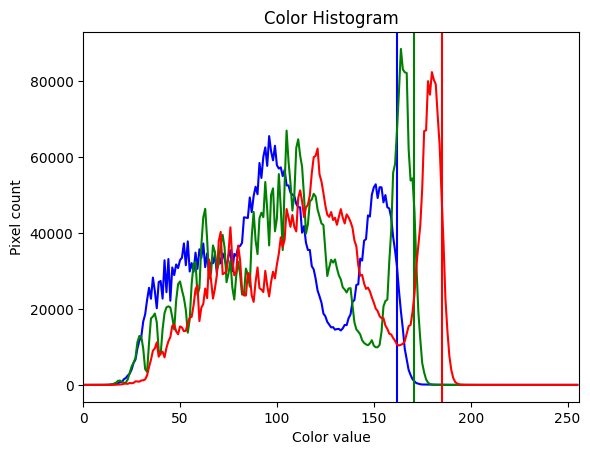

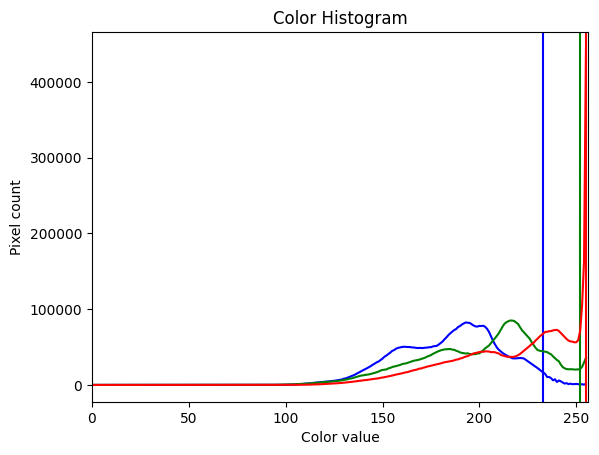

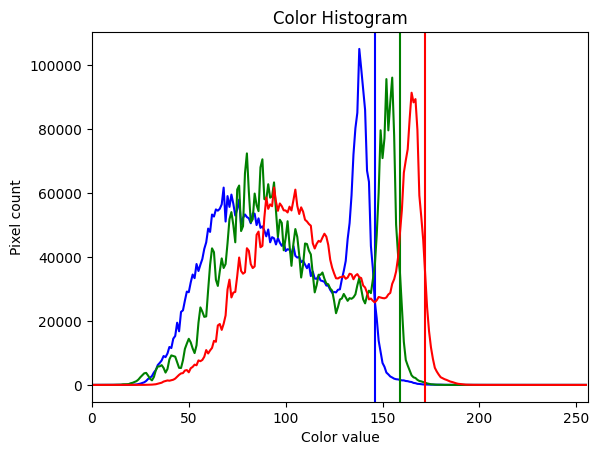

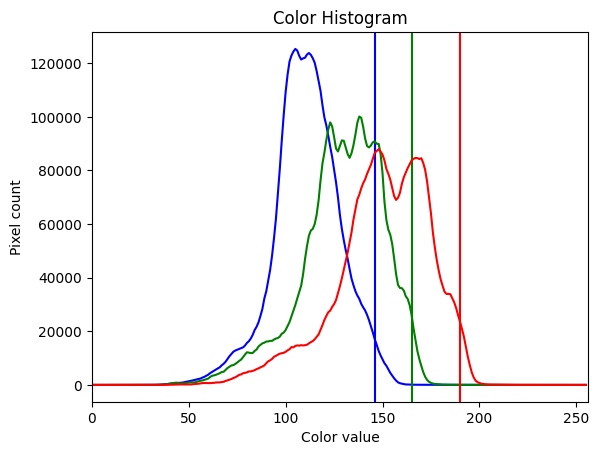

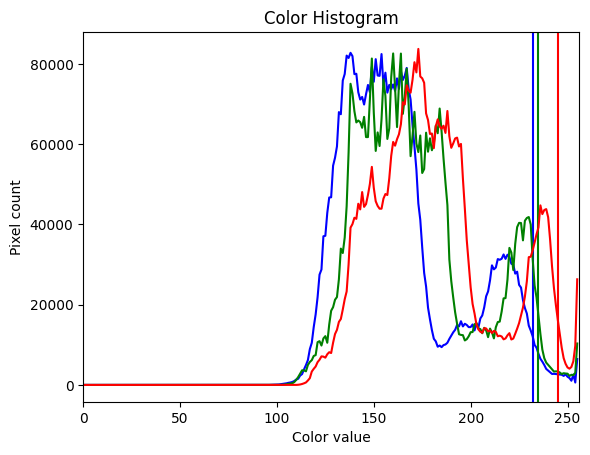

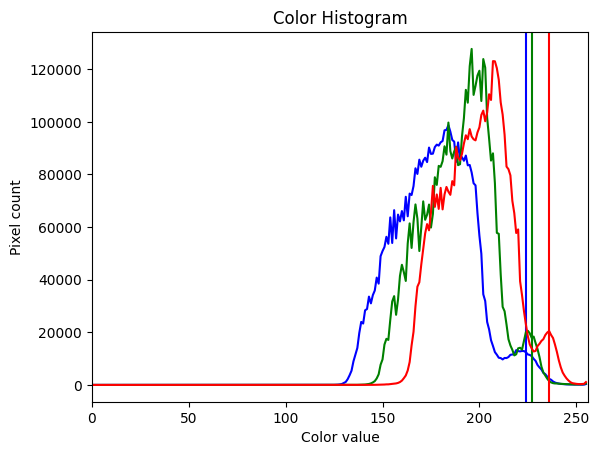

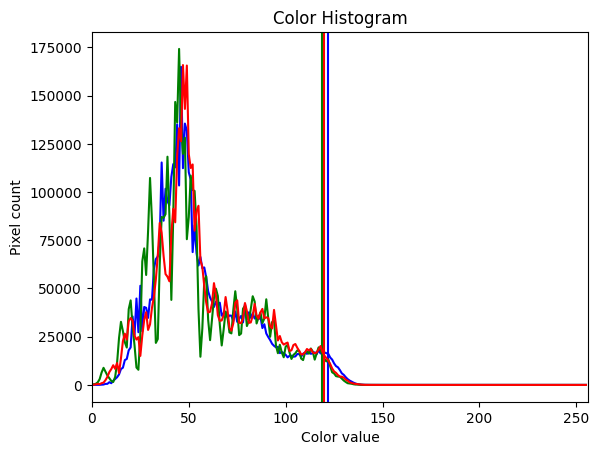

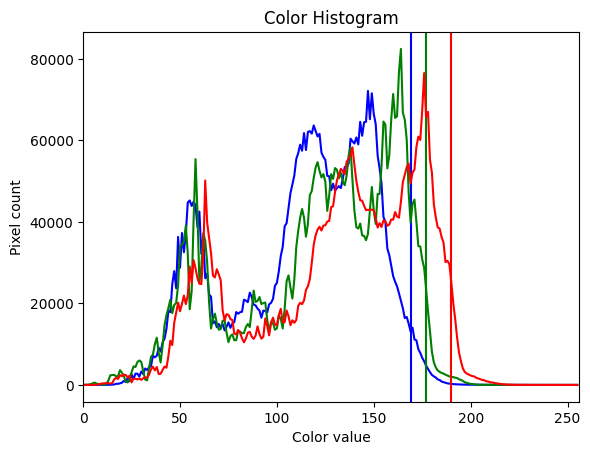

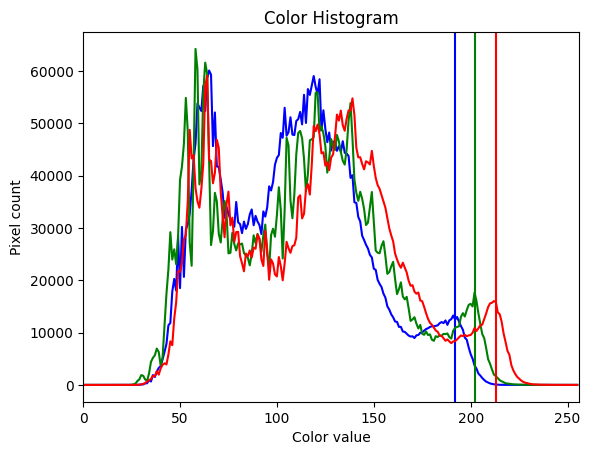

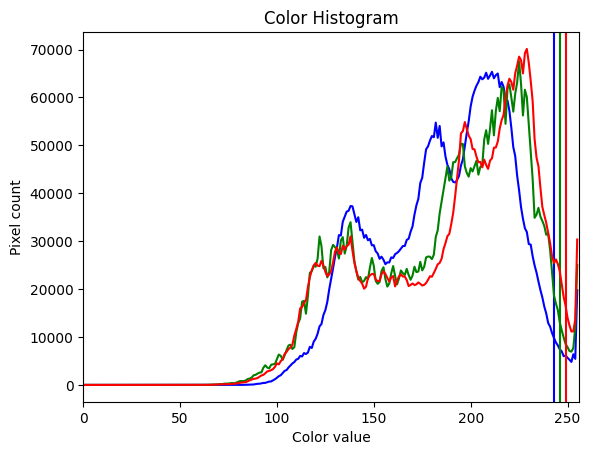

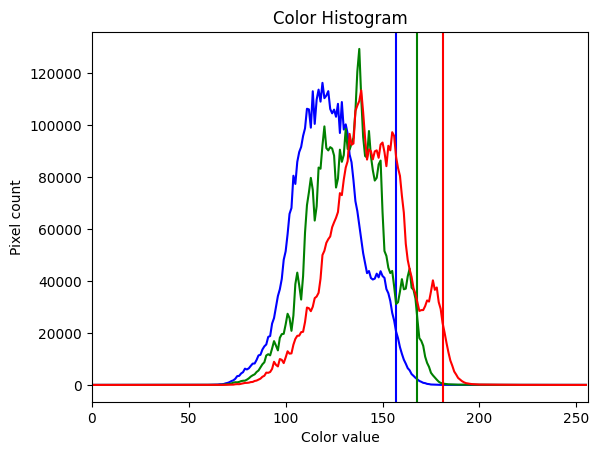

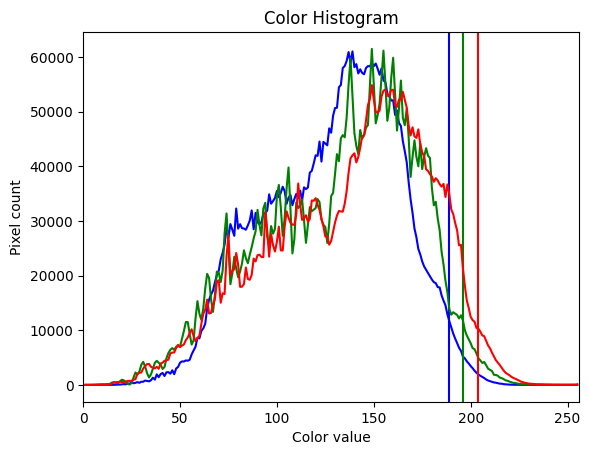

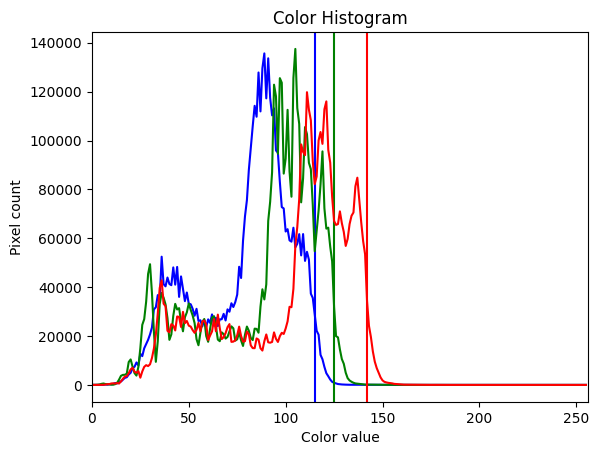

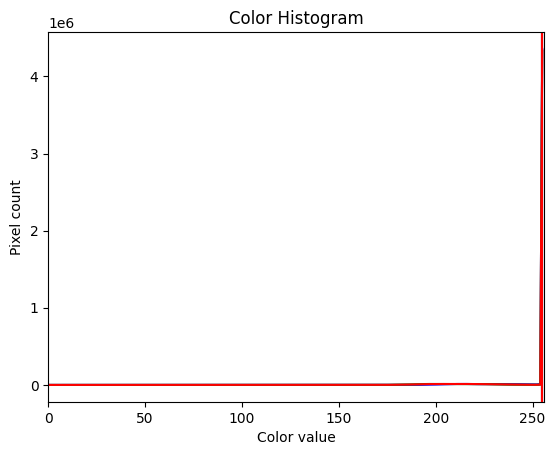

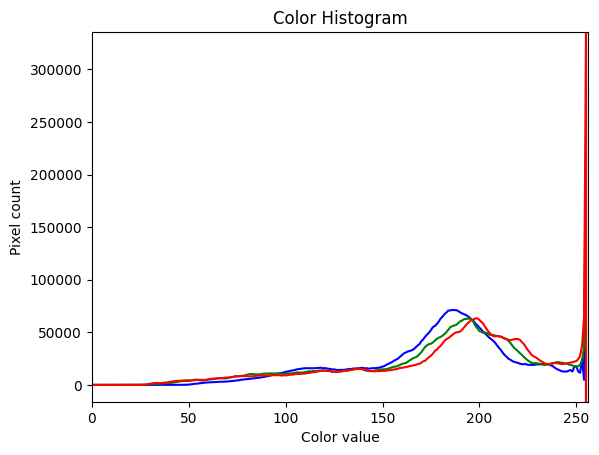

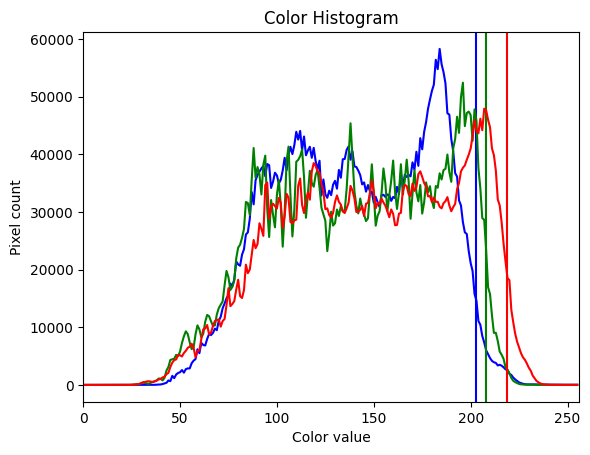

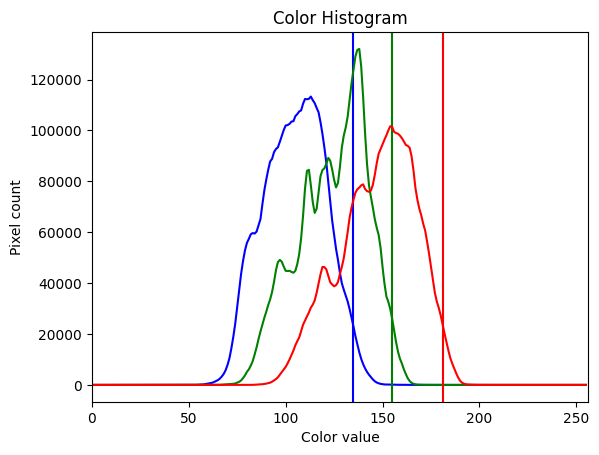

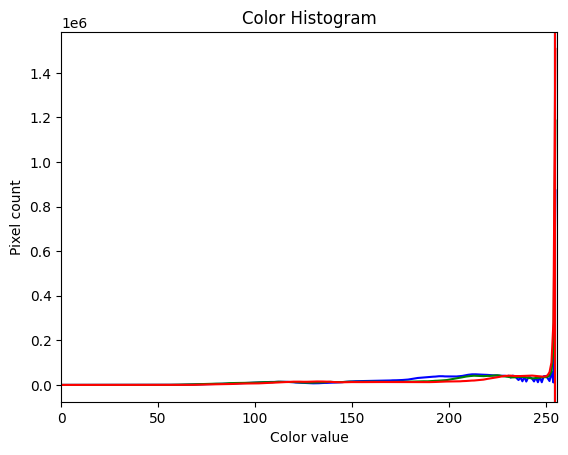

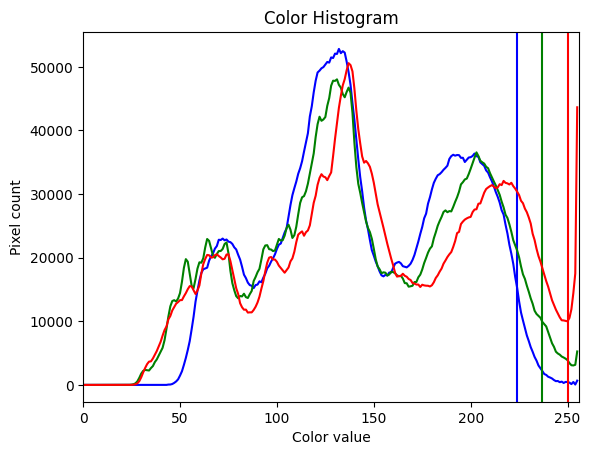

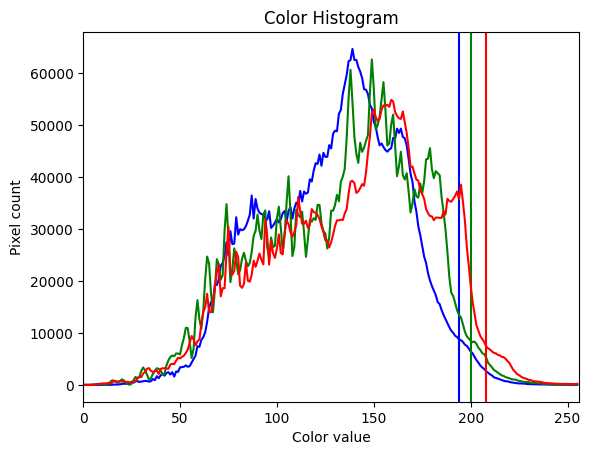

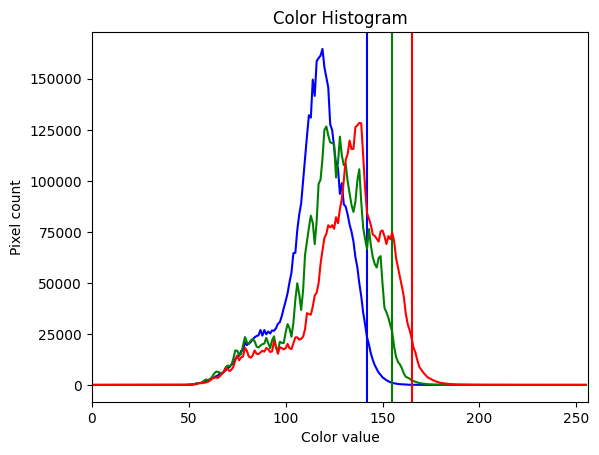

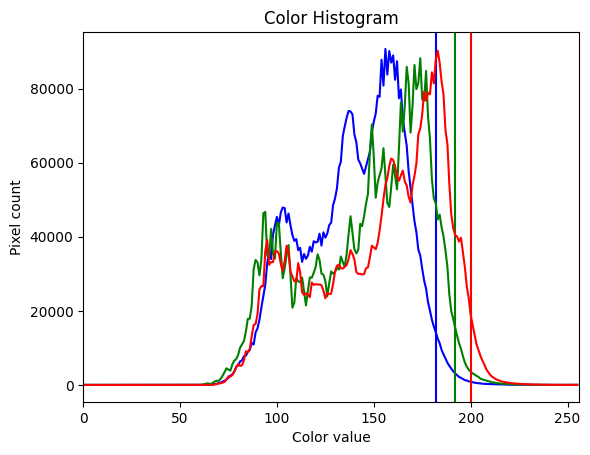

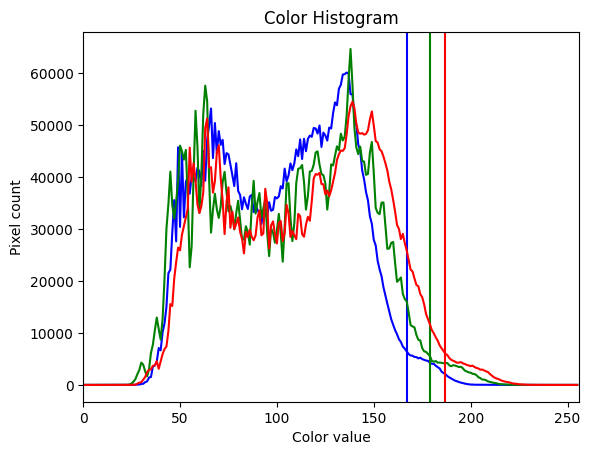

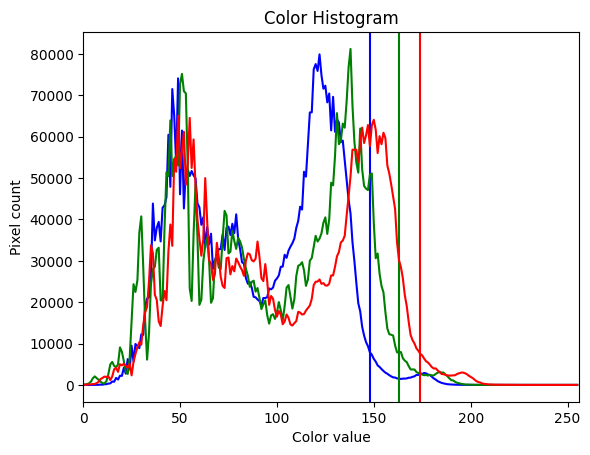

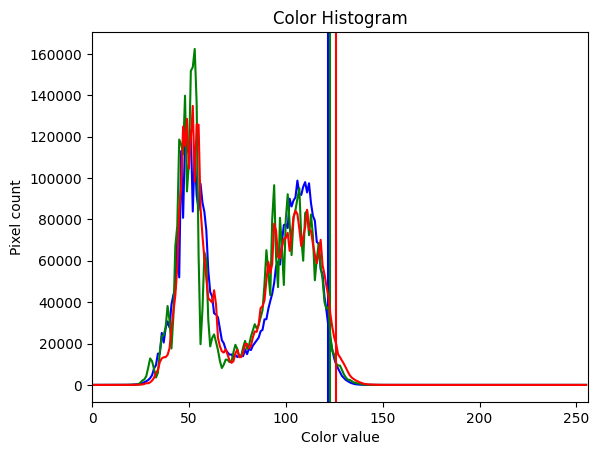

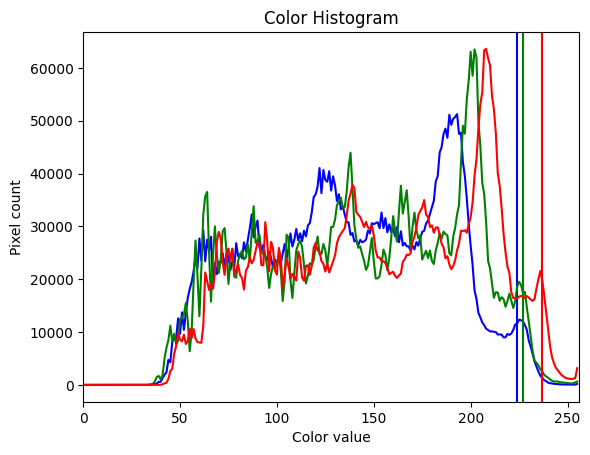

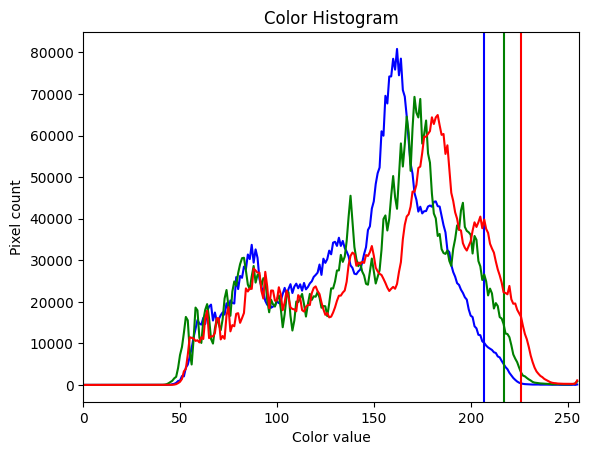

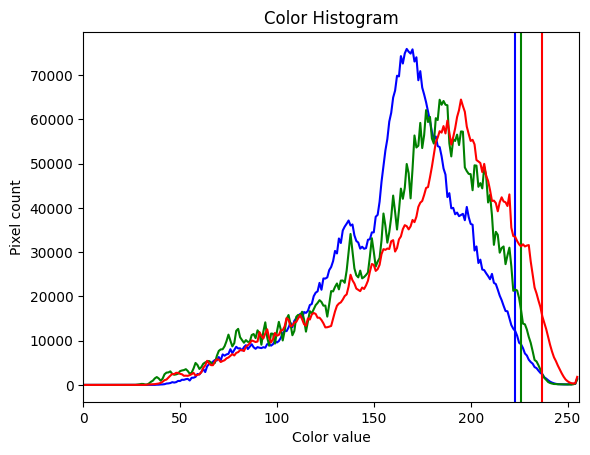

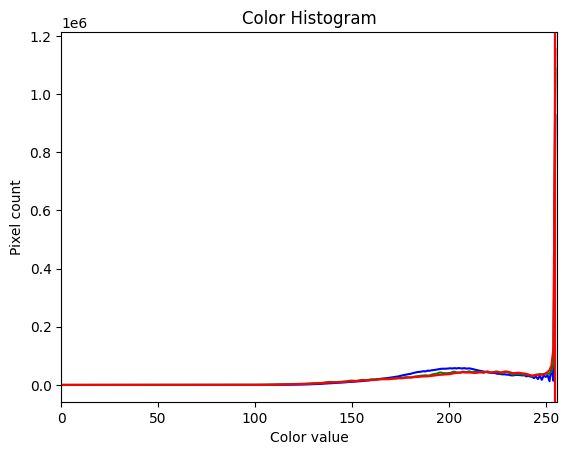

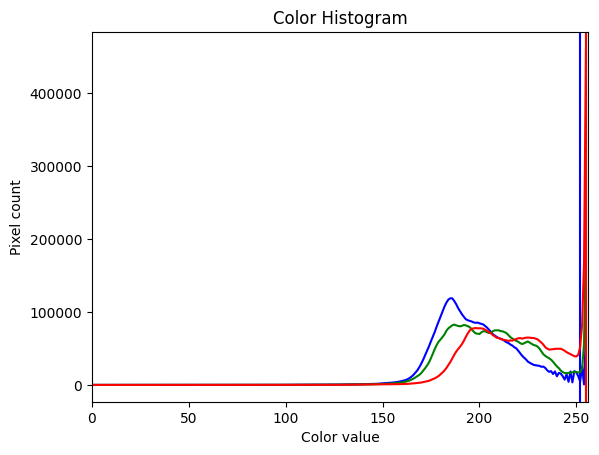

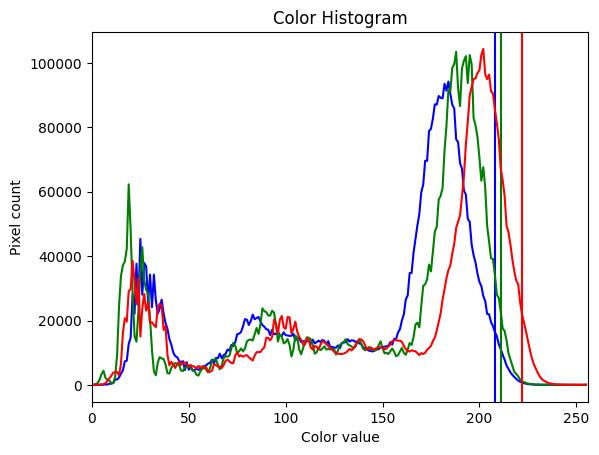

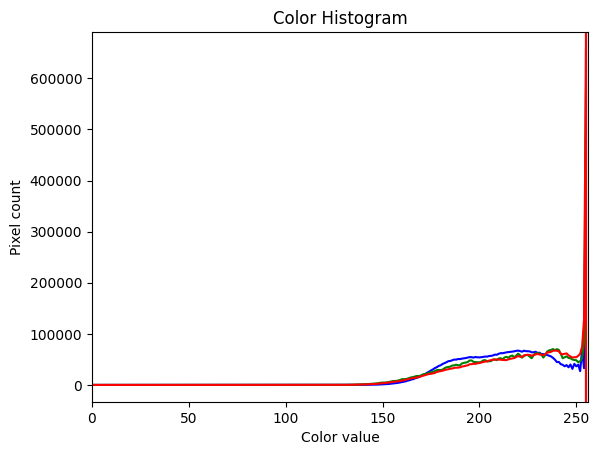

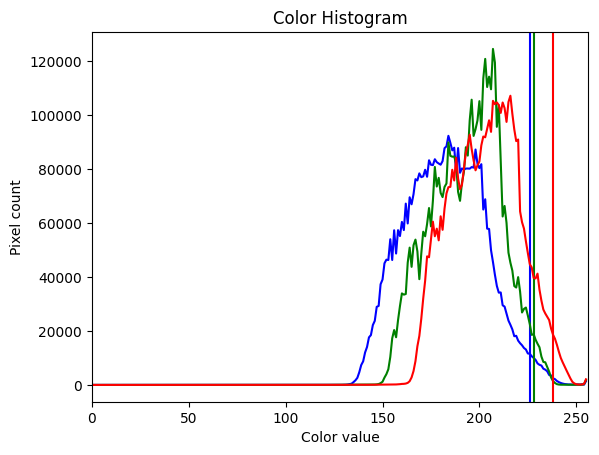

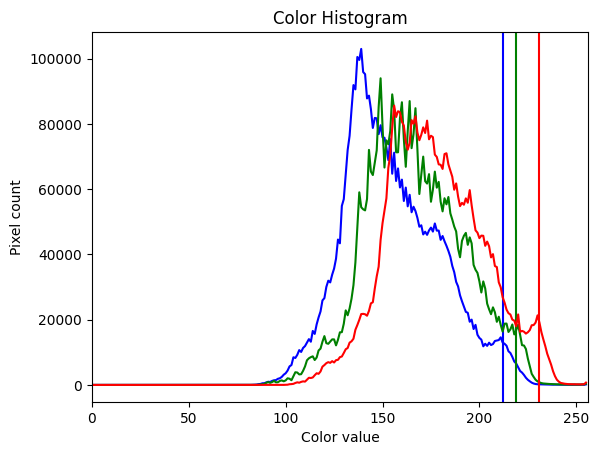

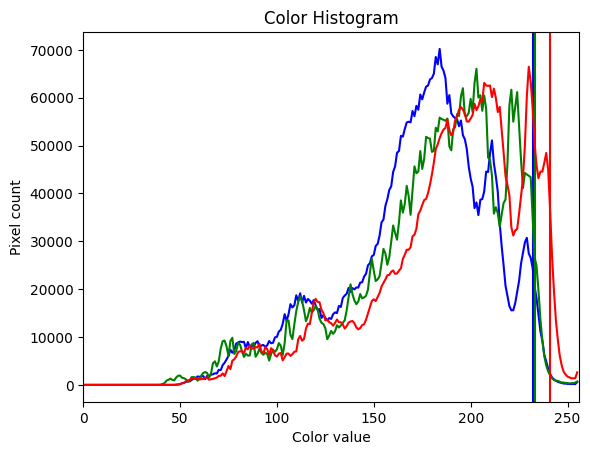

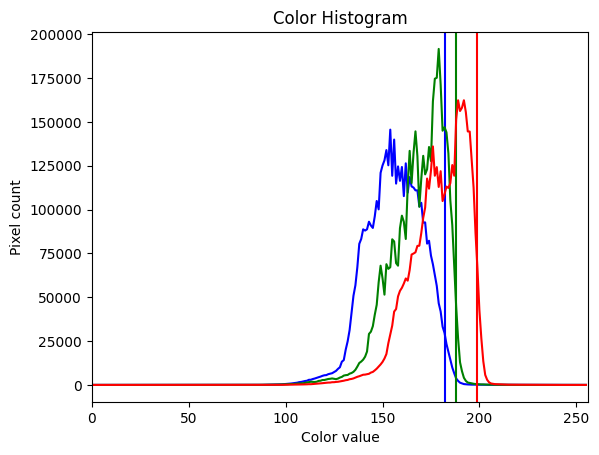

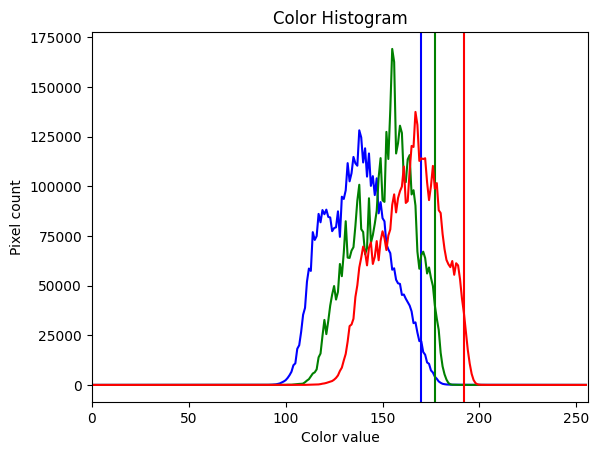

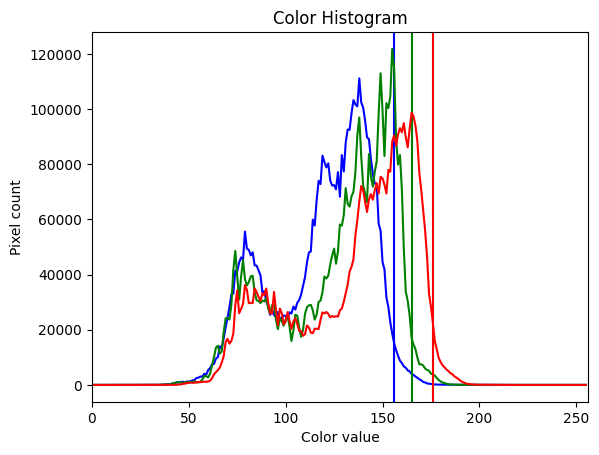

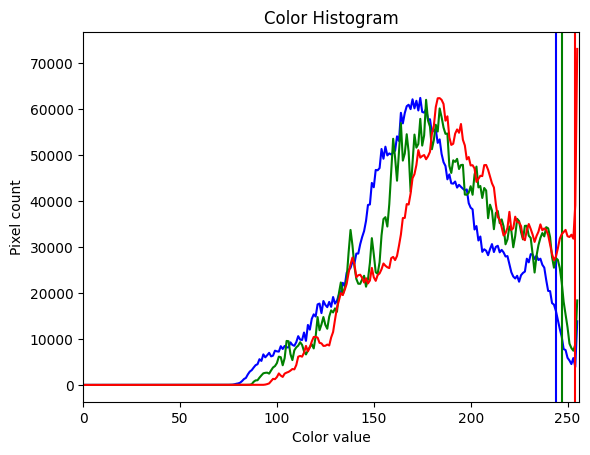

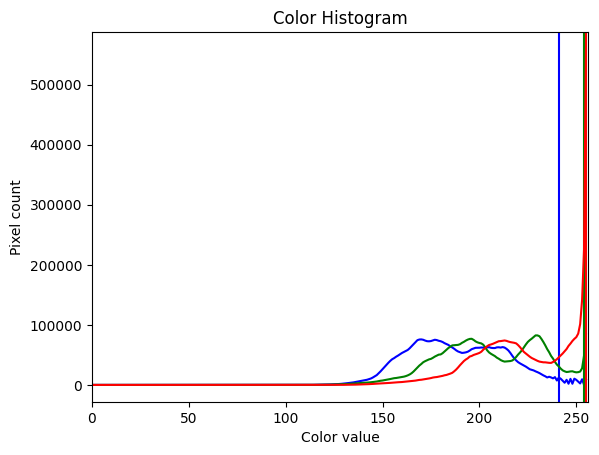

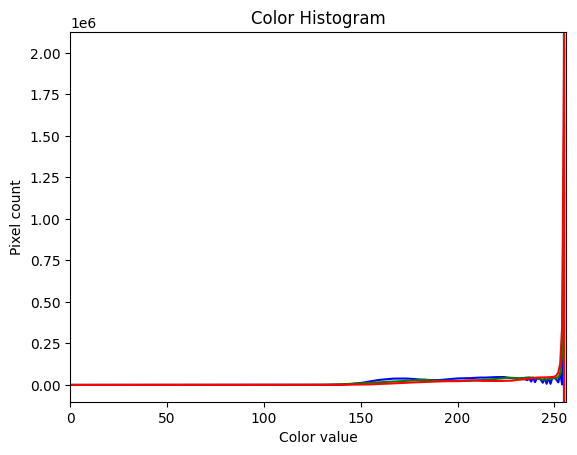

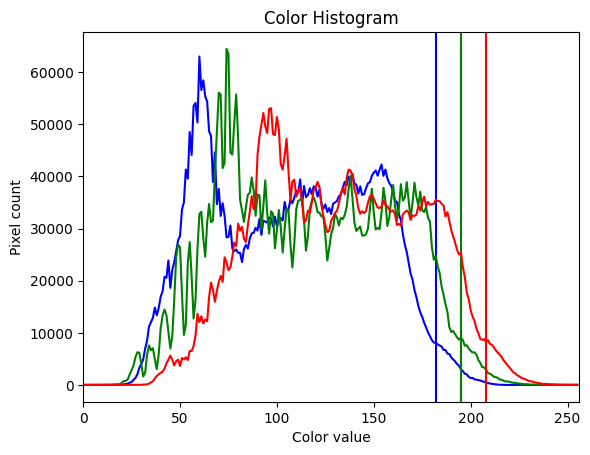

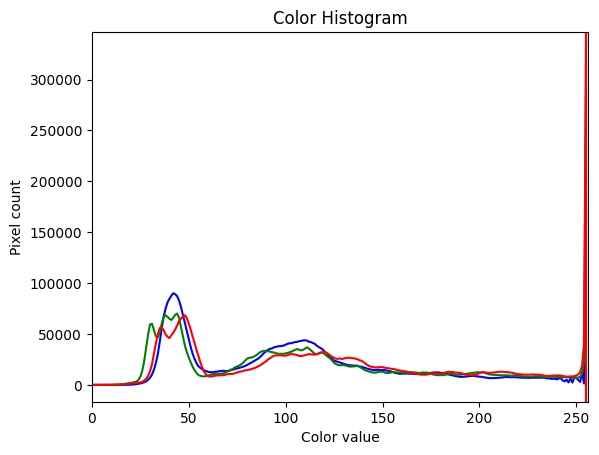

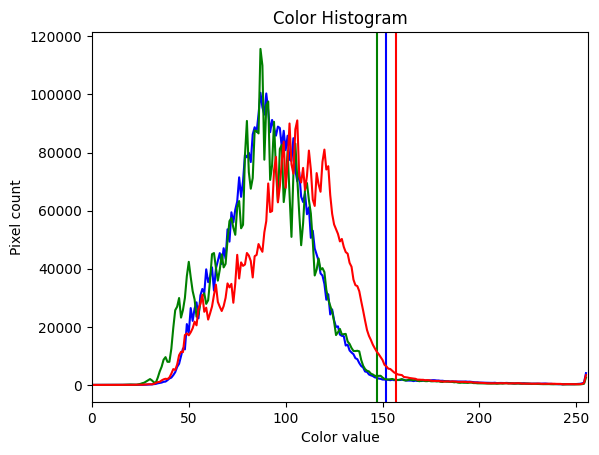

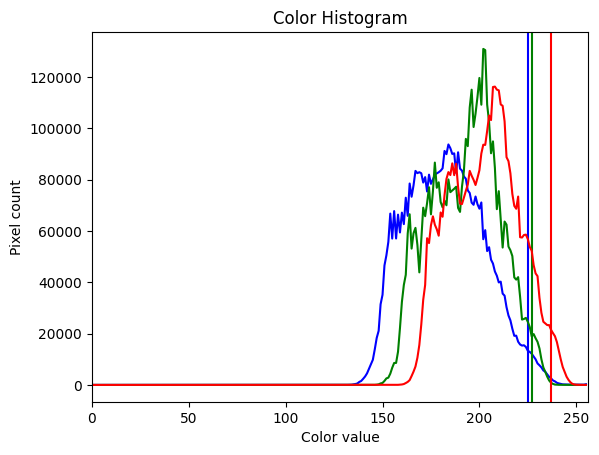

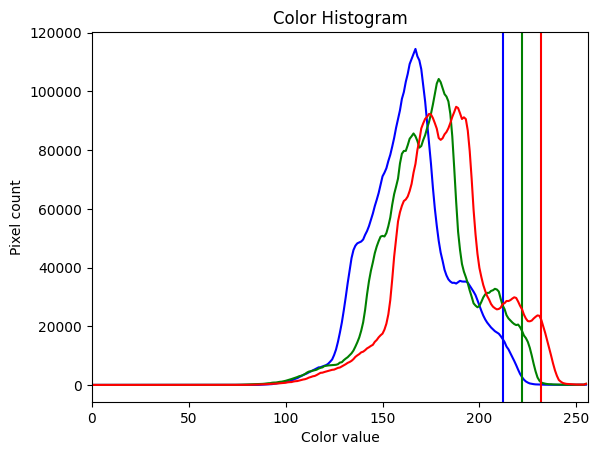

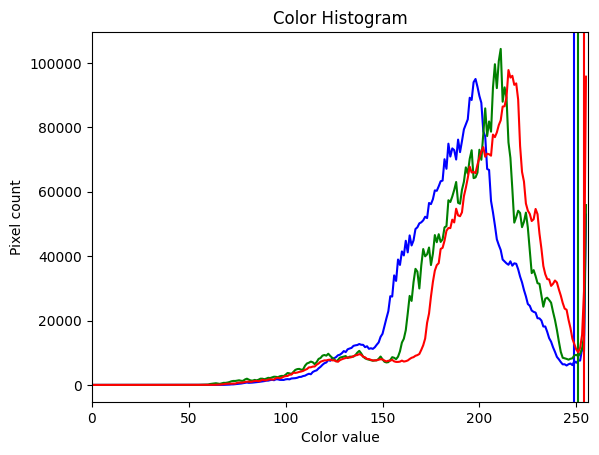

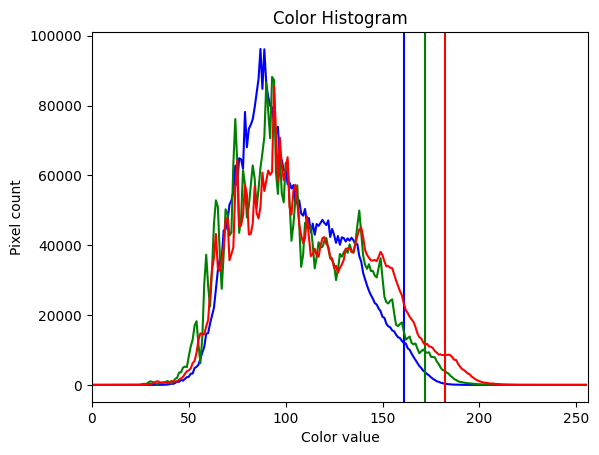

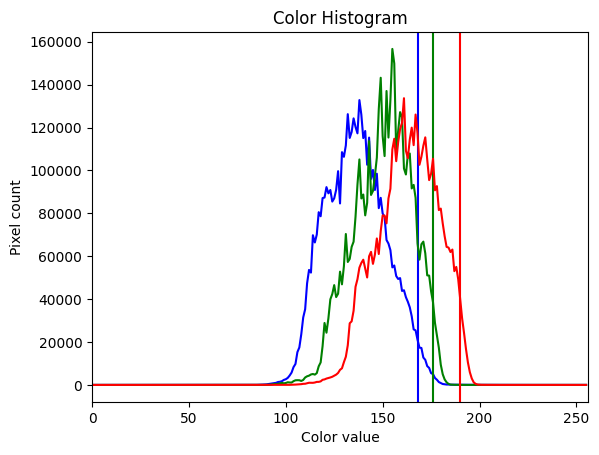

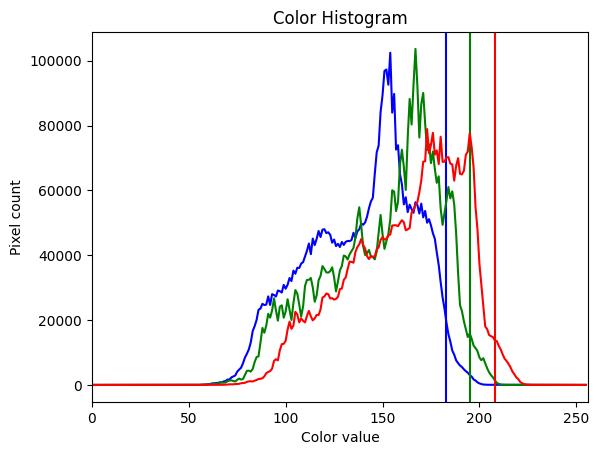

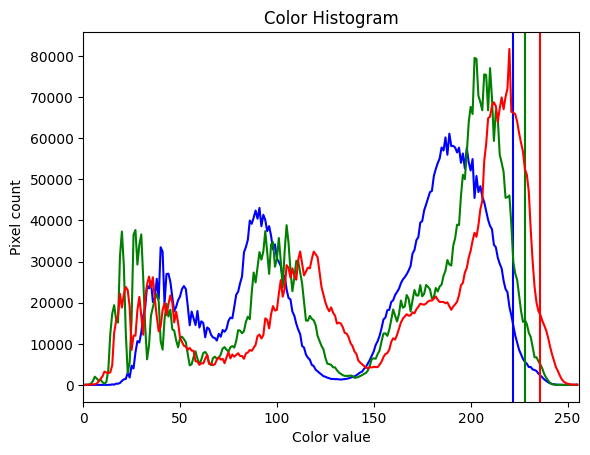

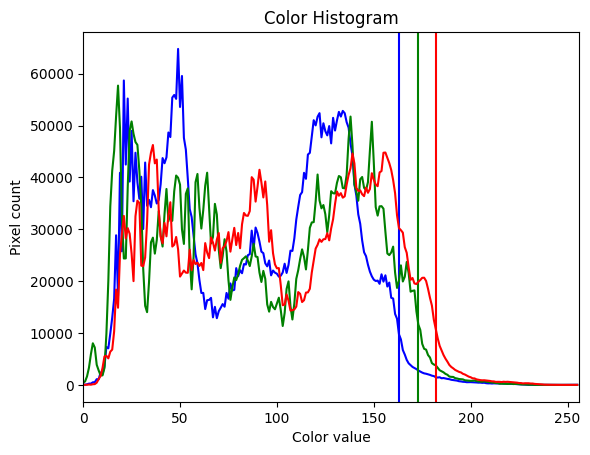

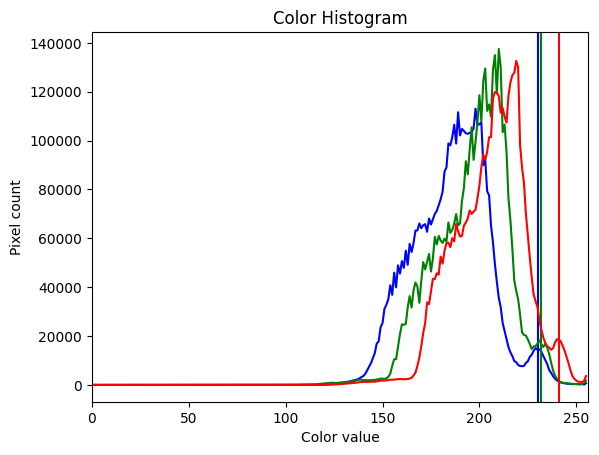

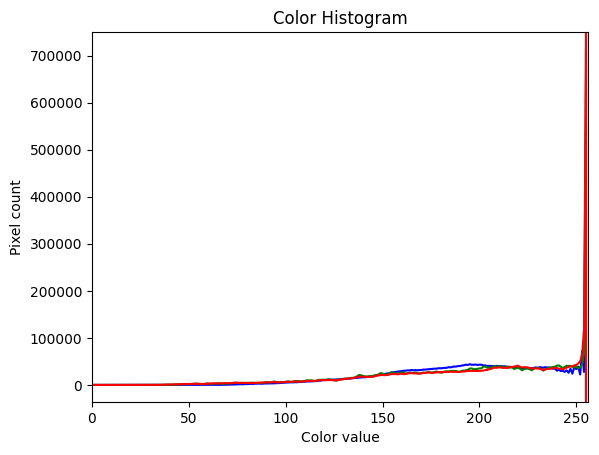

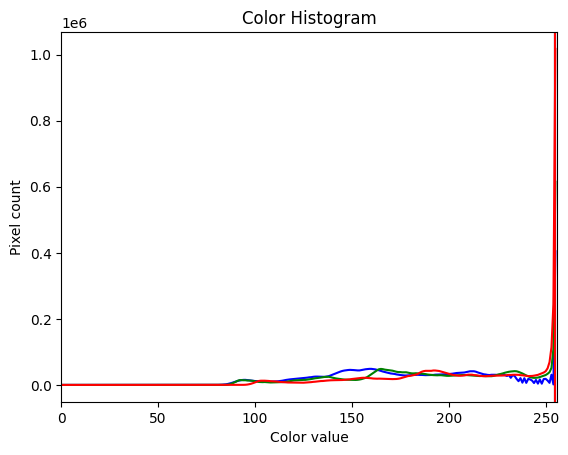

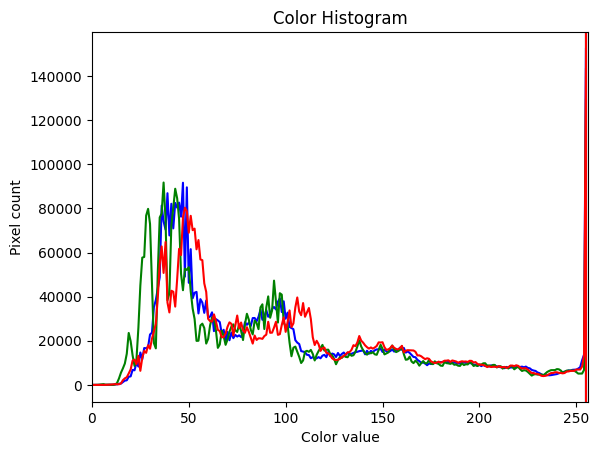

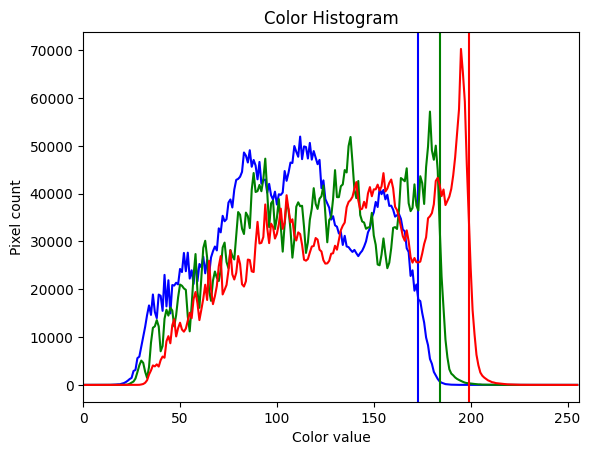

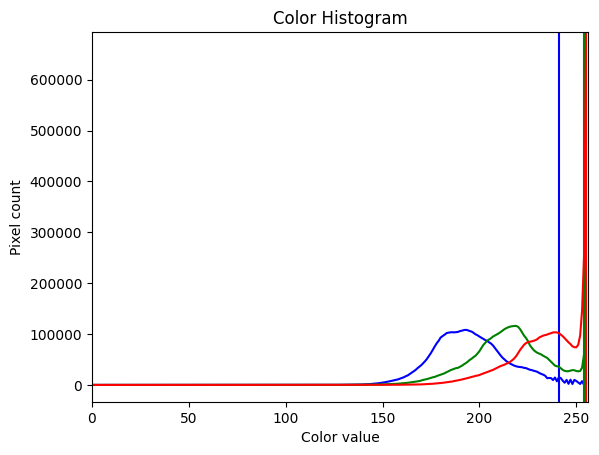

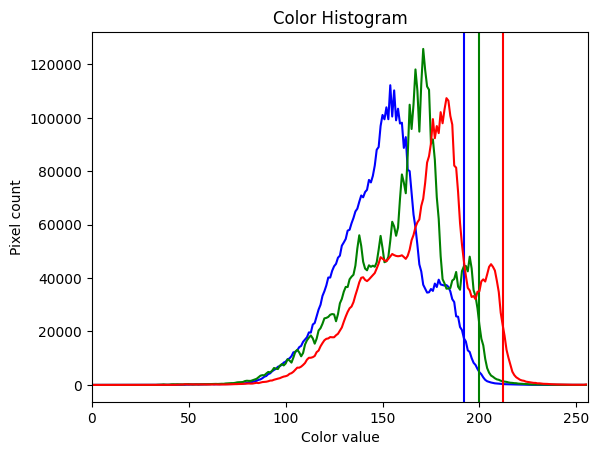

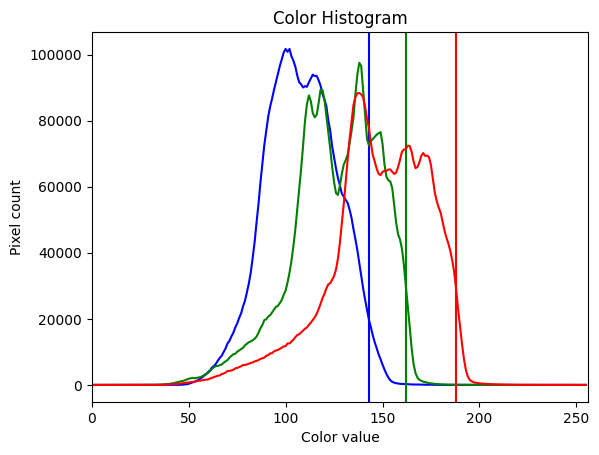

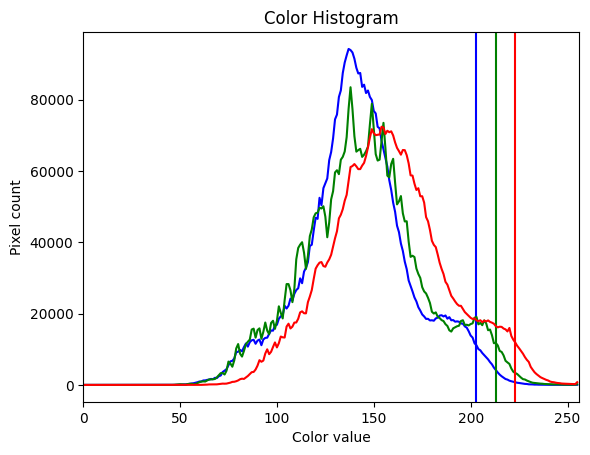

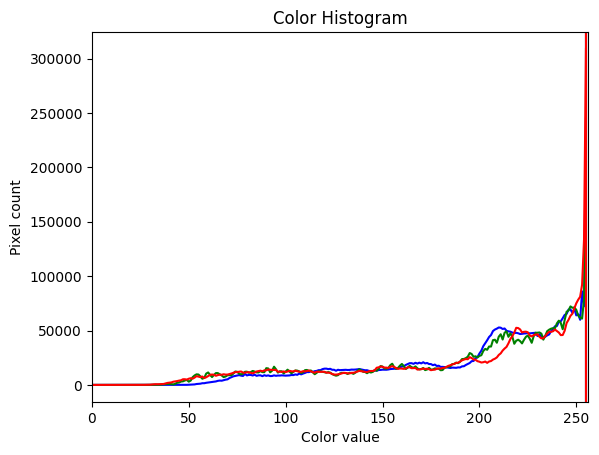

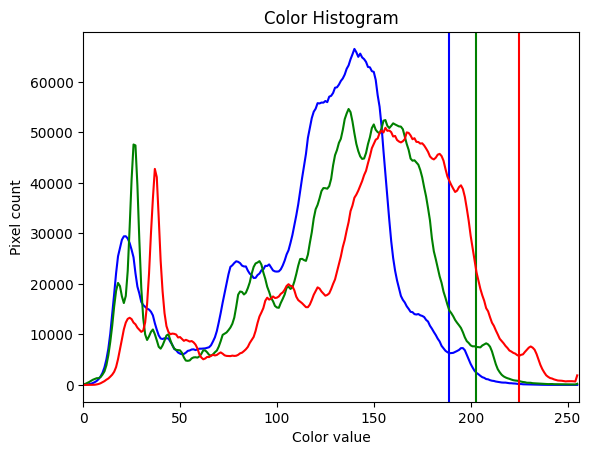

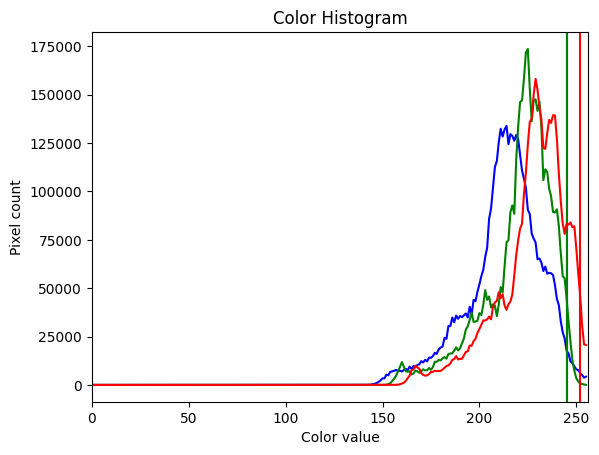

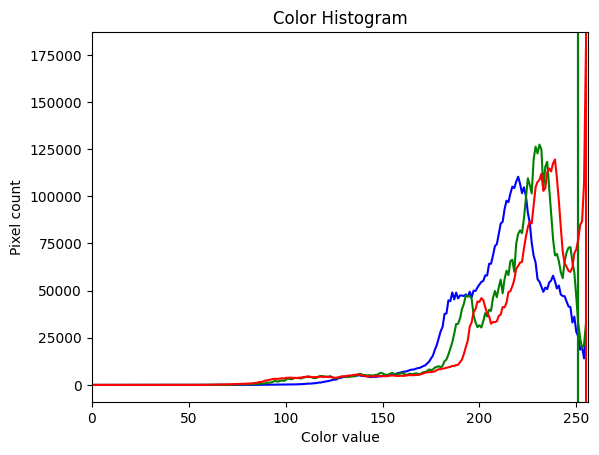

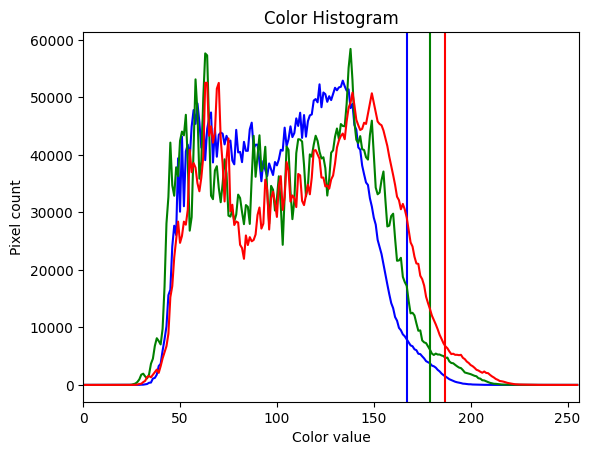

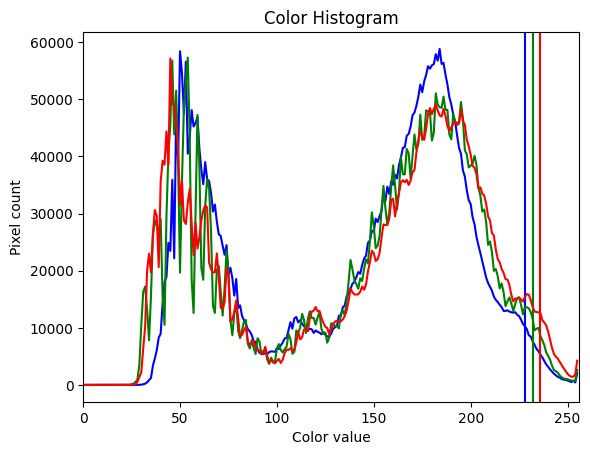

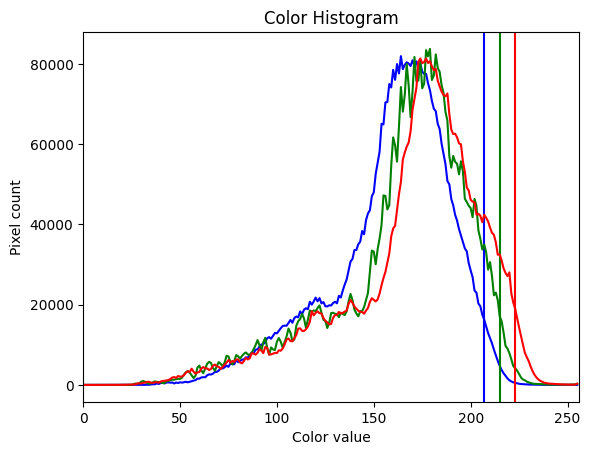

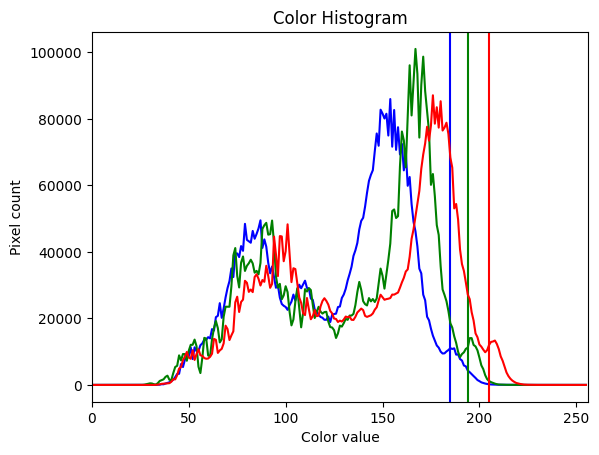

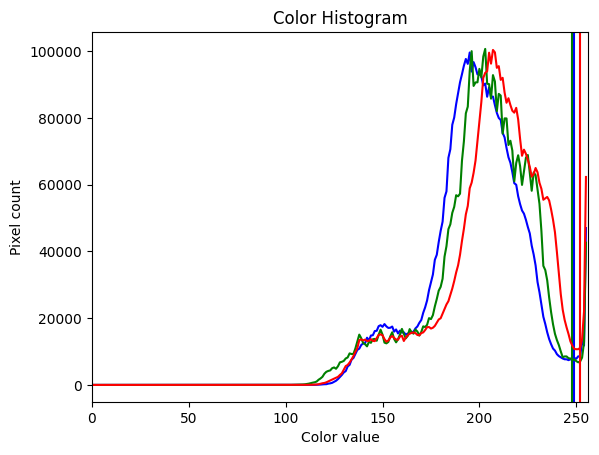

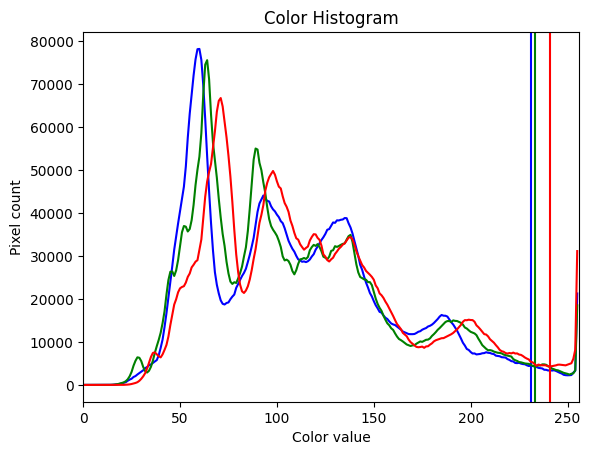

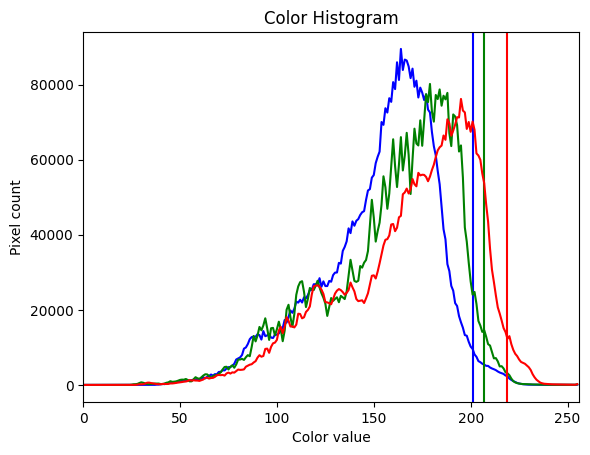

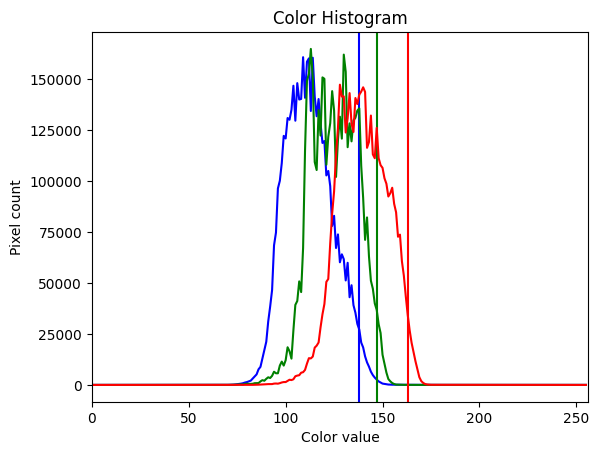

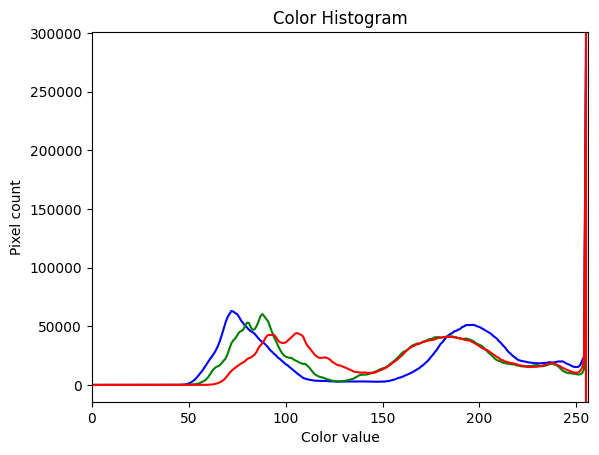

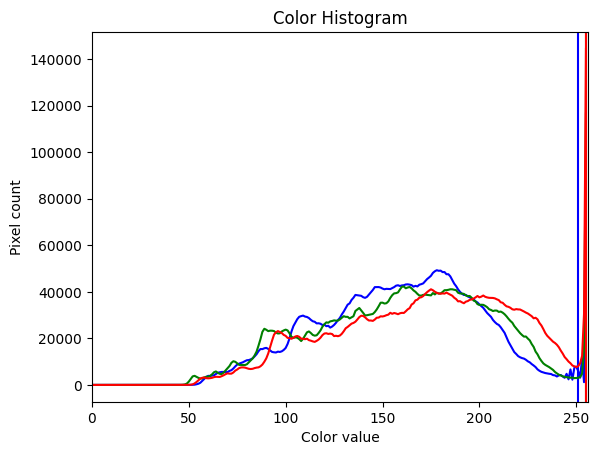

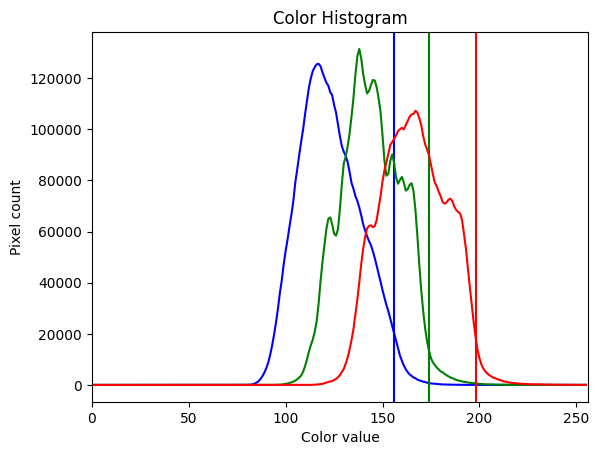

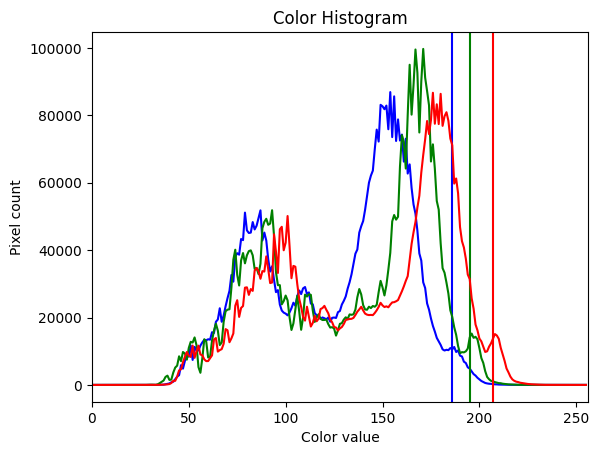

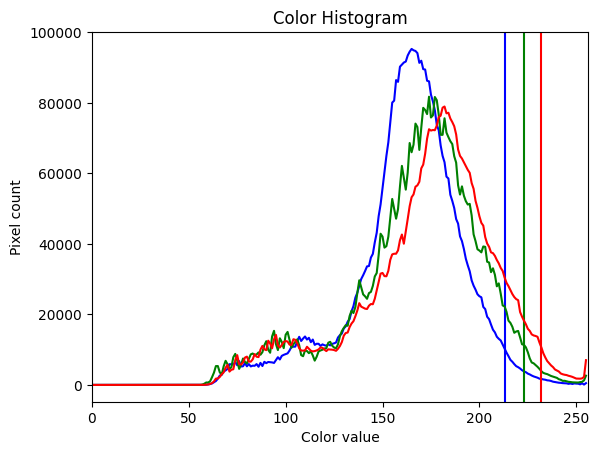

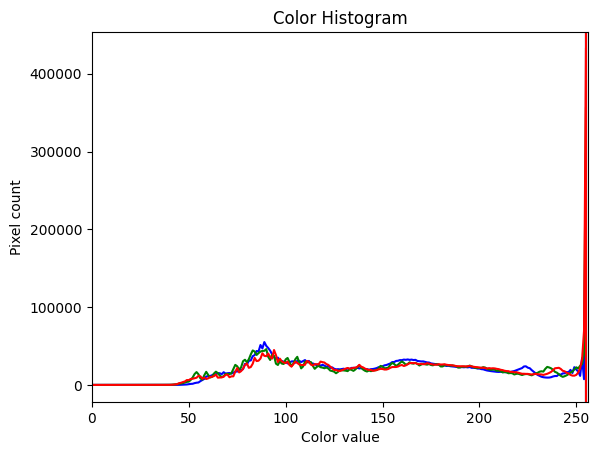

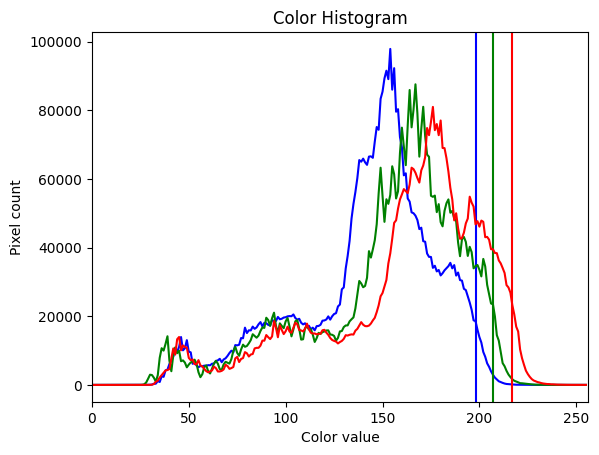

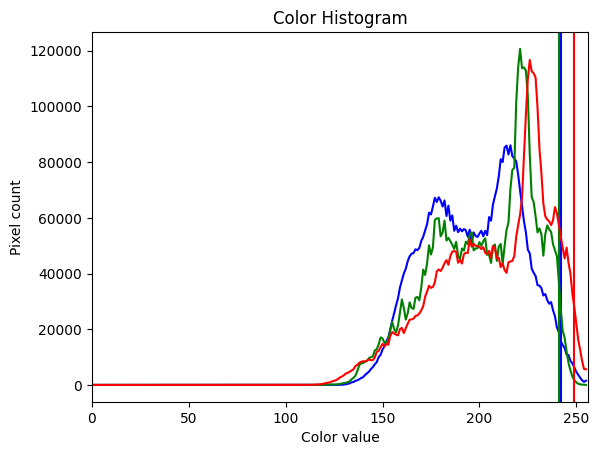

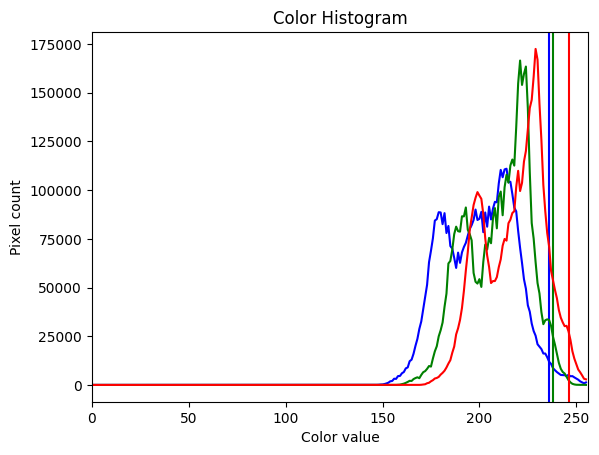

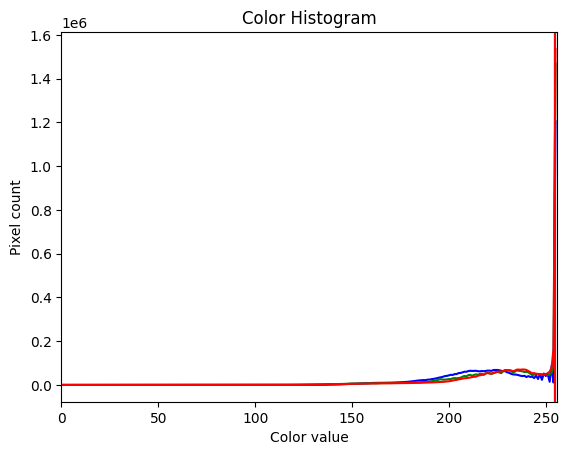

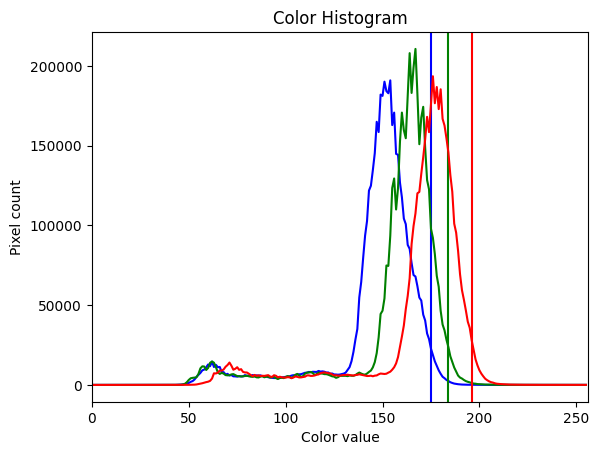

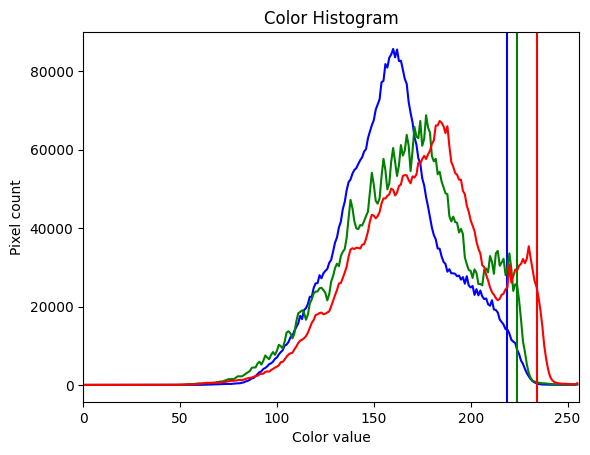

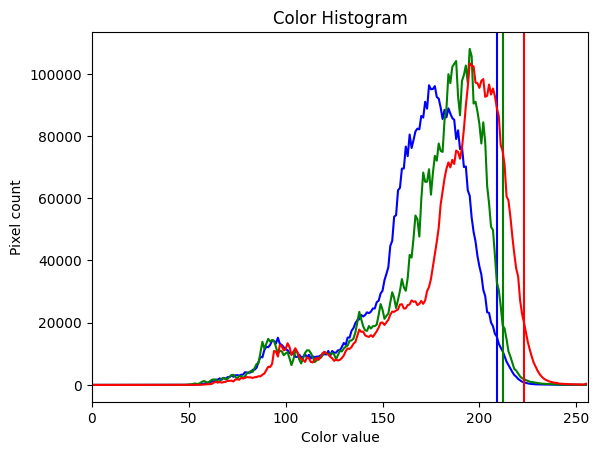

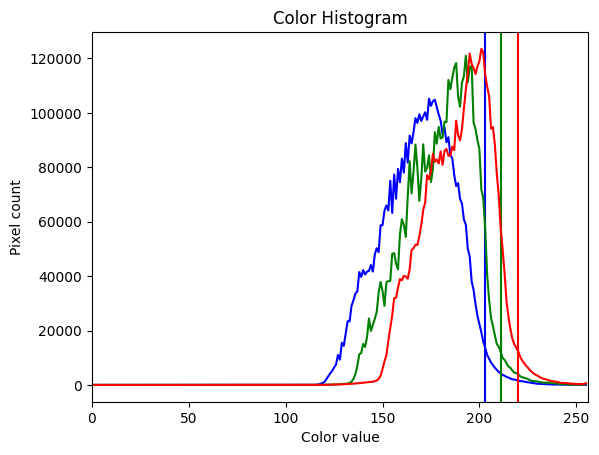

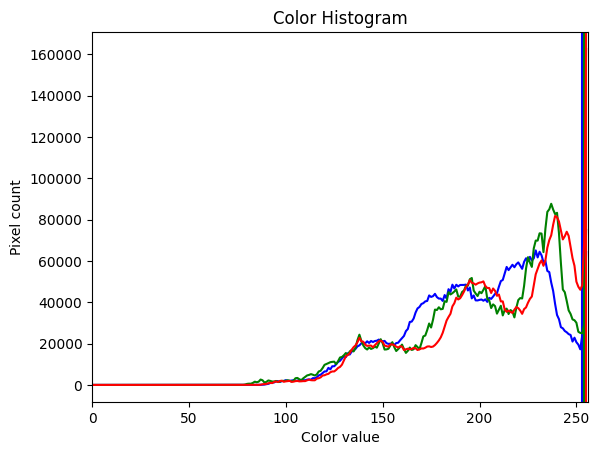

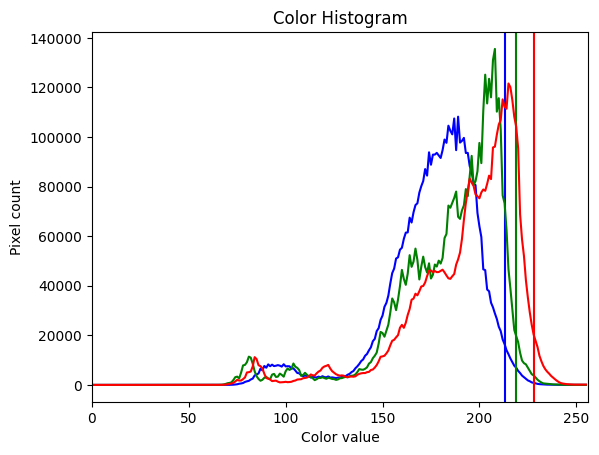

KeyboardInterrupt: 

In [97]:
# plot color histogram of training image
for file in os.listdir(trainimg_dir):
    if file.endswith('.jpg'):
        img = cv2.imread(os.path.join(trainimg_dir, file), cv2.IMREAD_COLOR)
        plotColorHist(img)

In [32]:
print(os.listdir(rawdata_dir))

['PI52606_1.czi', 'PI52606_2.czi', 'PI52606_3.czi']


In [8]:
testimg = AICSImage(os.path.join(rawdata_dir,'PI52606_1.czi'))
print(testimg.scenes[23])

testimg.set_scene(0)
print(testimg.shape)
testimg.set_scene('ScanRegion0')
print(testimg.shape)

ScanRegion23
(1, 1, 1, 6920, 16850, 3)
(1, 1, 1, 6920, 16850, 3)


# Test centering test image per-channel by training images

In [90]:
# apply centering 
scenes = []
titles = []
for scene in testimg.scenes:
    print(scene)
    
    # apply contrast stretching to each scene
    testimg.set_scene(scene)
    #print(testimg.dims)
    img = testimg.get_image_data("YXS", T=0,C=0,Z=0) # numpy.ndarray
    #plotColorHist(img)
    #csimg = contrastStretch(img)
    csimgc = centering2train(diff, img)
    scenes.append(csimgc)
    titles.append(scene)


ScanRegion0
ScanRegion1
ScanRegion2
ScanRegion3
ScanRegion4
ScanRegion5
ScanRegion6
ScanRegion7
ScanRegion8
ScanRegion9
ScanRegion10
ScanRegion11
ScanRegion12
ScanRegion13
ScanRegion14
ScanRegion15
ScanRegion16
ScanRegion17
ScanRegion18
ScanRegion19
ScanRegion20
ScanRegion21
ScanRegion22
ScanRegion23


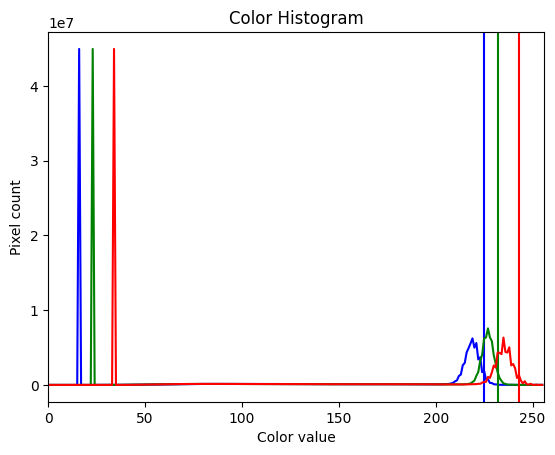

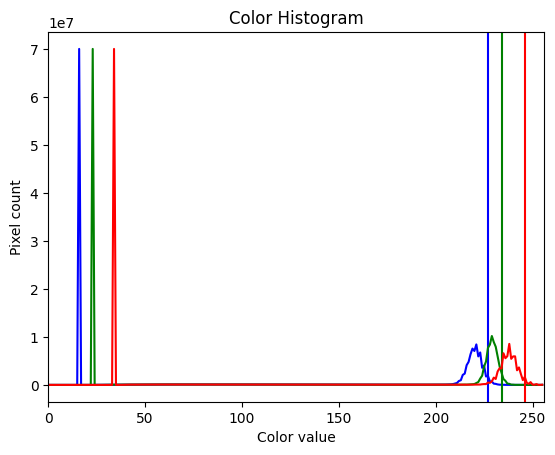

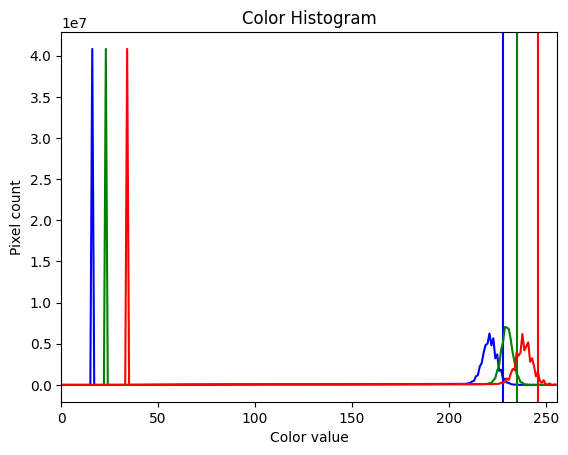

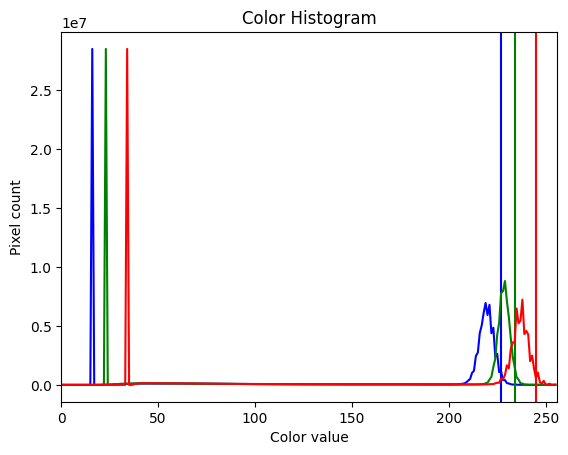

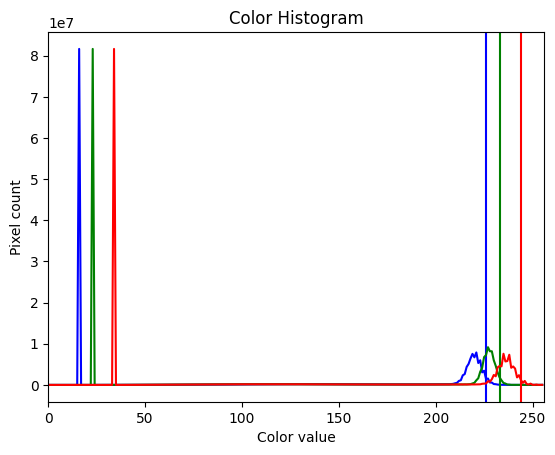

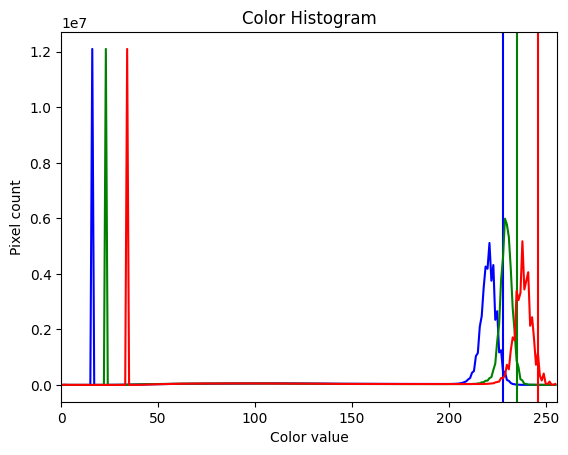

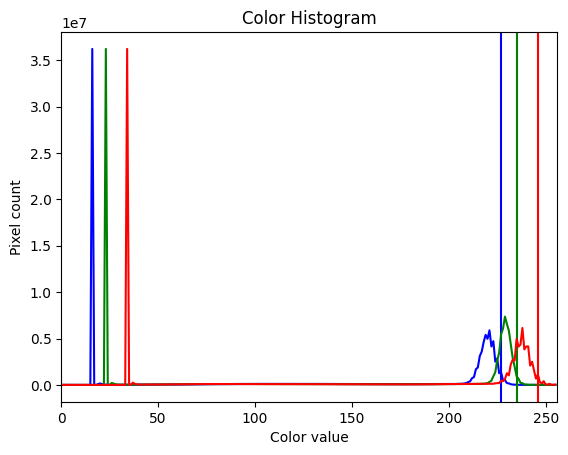

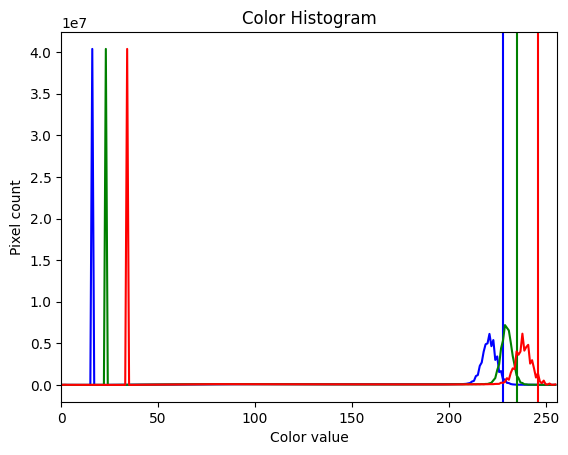

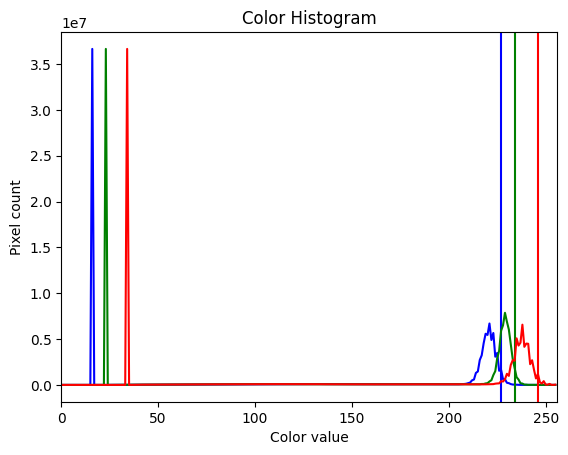

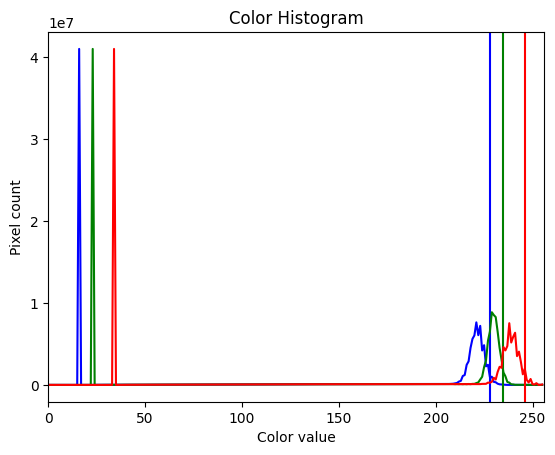

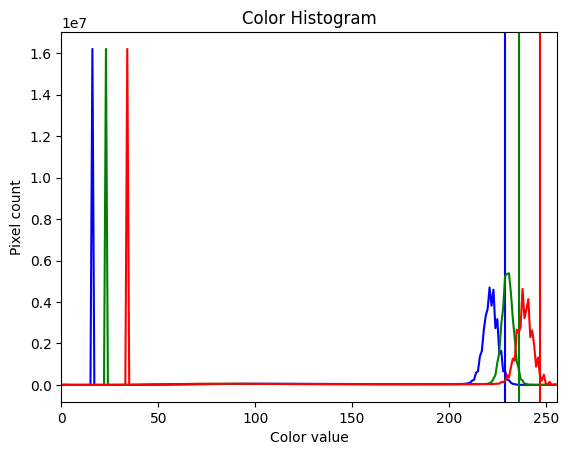

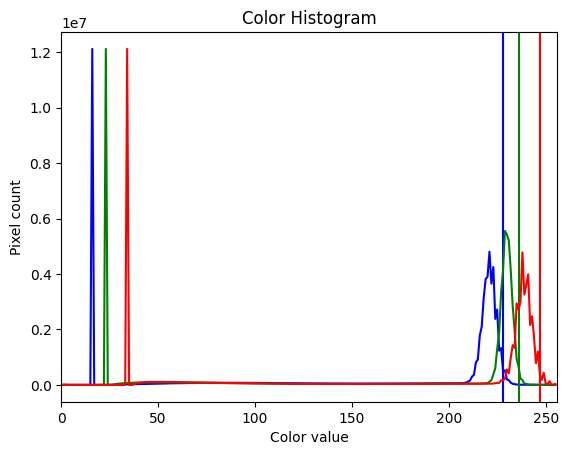

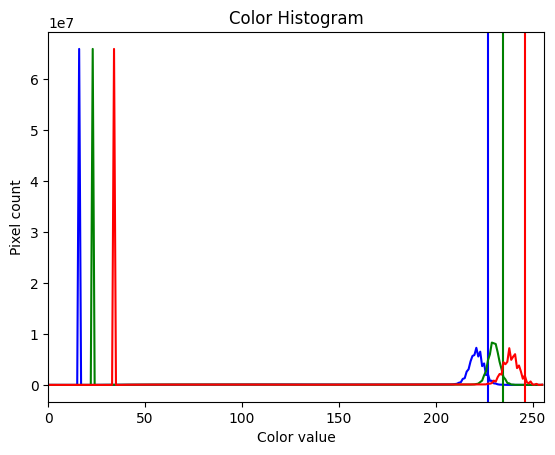

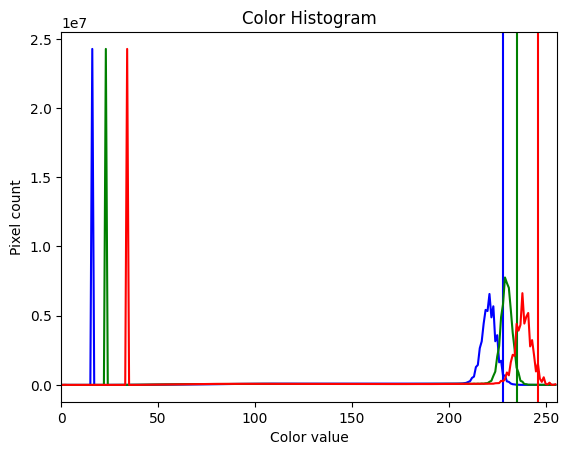

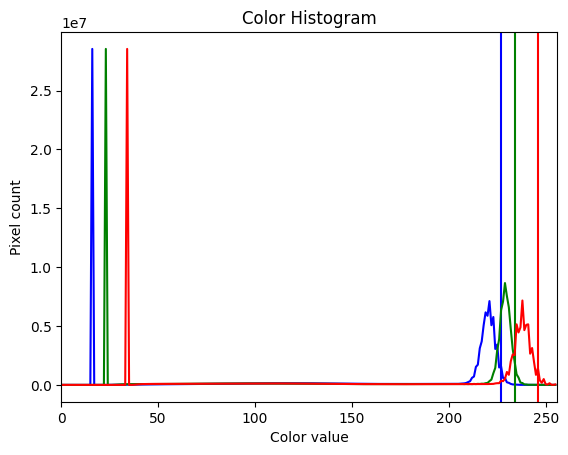

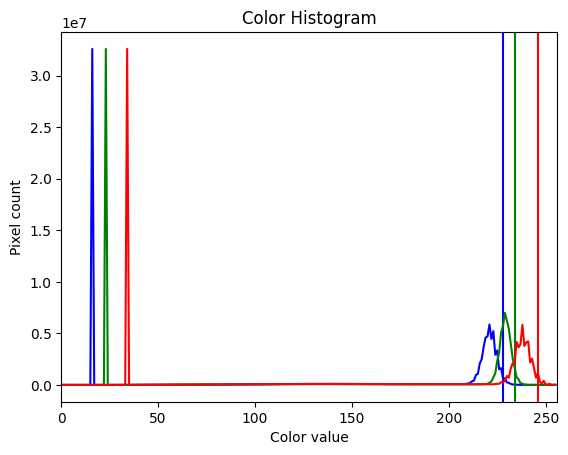

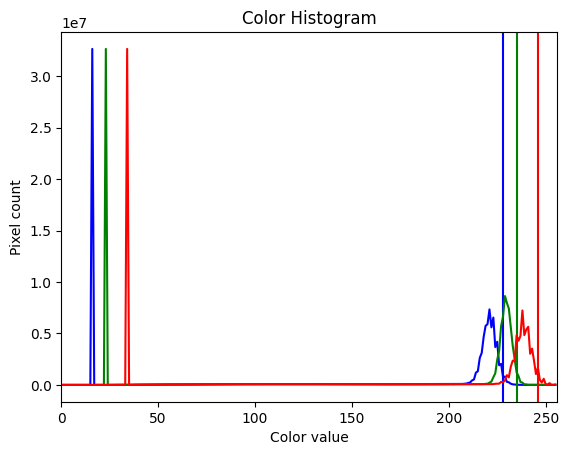

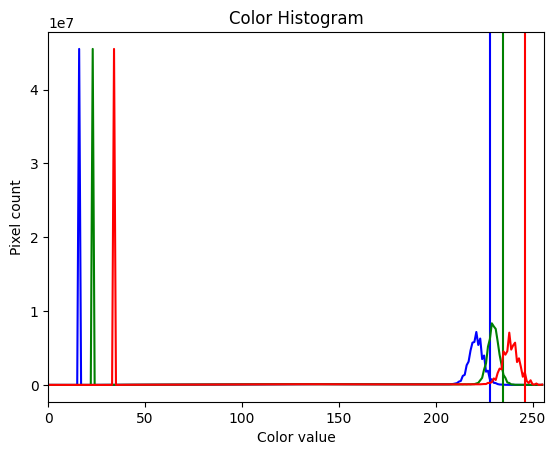

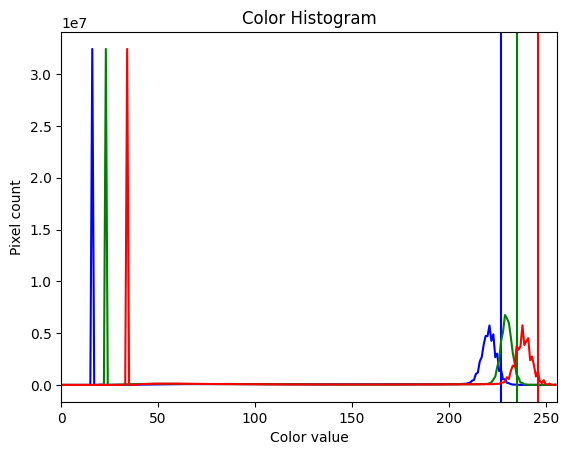

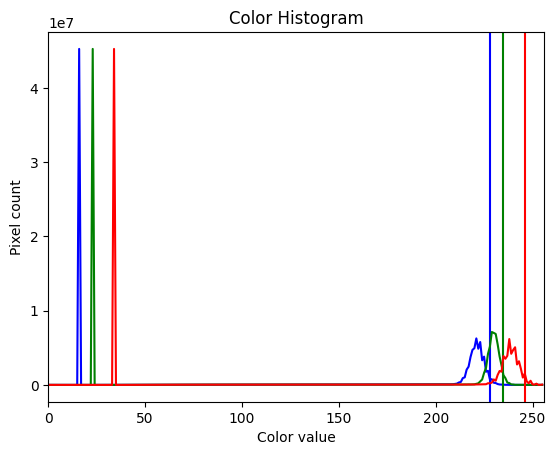

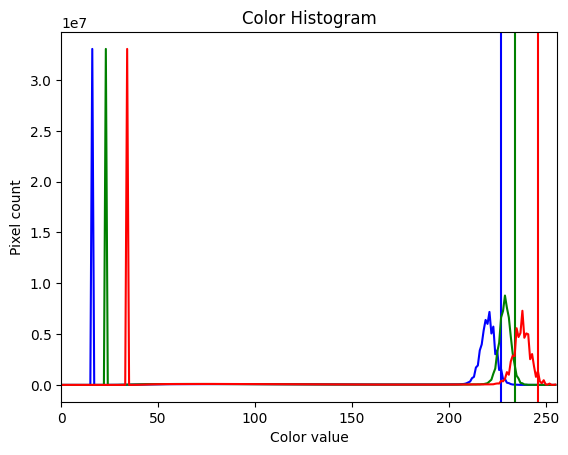

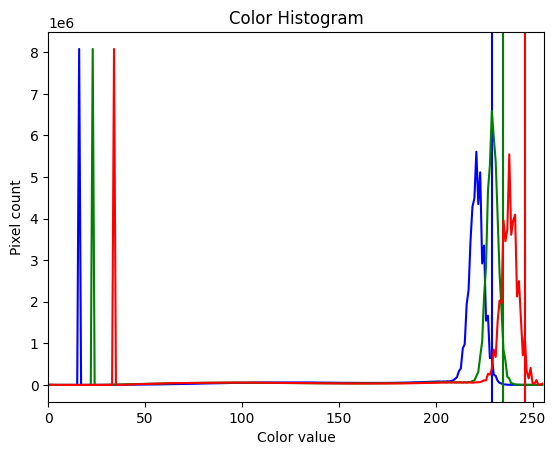

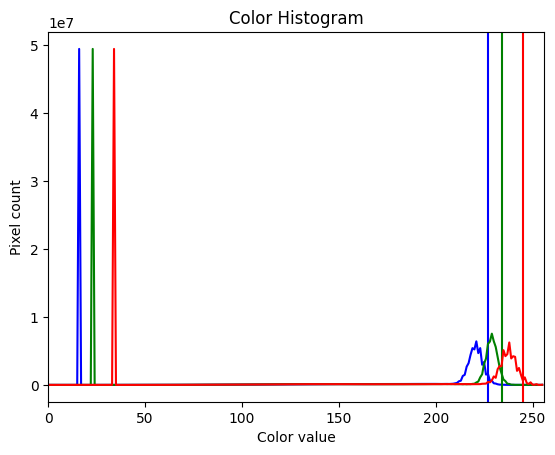

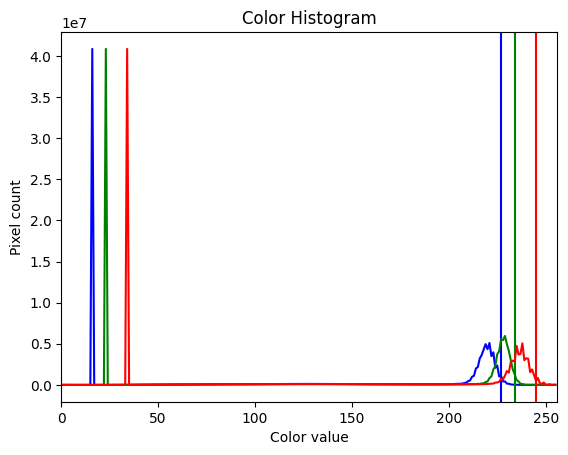

In [91]:
for img in scenes:
    plotColorHist(img)

In [96]:
cv2.imshow('',scenes[4])
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

# Centering and tiling axioscan images to the size of training images

In [99]:
for file in os.listdir(rawdata_dir):
    print(file)
    czifile = AICSImage(os.path.join(rawdata_dir,file))
    for scene in czifile.scenes:
        print(scene)
        czifile.set_scene(scene)
        #print(testimg.dims)
        img = czifile.get_image_data("YXS", T=0,C=0,Z=0) # numpy.ndarray
        #print(img.shape)
        
        # centering by training image per-channel mean
        csimgc = centering2train(diff, img)
        
        # pad the image to be dividible by tile size
        img = padImg(img, 2560, 1920)
        #print(img.shape)
        
        # crop images to tiles
        tiles = makeTiles(file, scene, img, 2560, 1920, output_dir)
        #print(tiles)

PI52606_1.czi
ScanRegion0
ScanRegion1
ScanRegion2
ScanRegion3
ScanRegion4
ScanRegion5
ScanRegion6
ScanRegion7
ScanRegion8
ScanRegion9
ScanRegion10
ScanRegion11
ScanRegion12
ScanRegion13
ScanRegion14
ScanRegion15
ScanRegion16
ScanRegion17
ScanRegion18
ScanRegion19
ScanRegion20
ScanRegion21
ScanRegion22
ScanRegion23
PI52606_2.czi
ScanRegion0
ScanRegion1
ScanRegion2
ScanRegion3
ScanRegion4
ScanRegion5
ScanRegion6
ScanRegion7
ScanRegion8
ScanRegion9
ScanRegion10
ScanRegion11
ScanRegion12
ScanRegion13
ScanRegion14
ScanRegion15
ScanRegion16
ScanRegion17
ScanRegion18
ScanRegion19
ScanRegion20
ScanRegion21
ScanRegion22
ScanRegion23
ScanRegion24
ScanRegion25
ScanRegion26
ScanRegion27
ScanRegion28
ScanRegion29
PI52606_3.czi
ScanRegion1
ScanRegion2
ScanRegion3
ScanRegion4
ScanRegion5
ScanRegion6
ScanRegion7
ScanRegion8
ScanRegion9
ScanRegion10
ScanRegion11
ScanRegion12
ScanRegion13
ScanRegion14
ScanRegion15
ScanRegion16
ScanRegion17
ScanRegion18
ScanRegion19
ScanRegion20
ScanRegion21
ScanRegion22